# Analysis on Electricity generation emissions trends and Energy Sources
- Student ID: 3040688758
- Name: Seoyeon Kang


### What I did in the final project
- function to import the organized form of emissions data directly from the climatetrace api, by inputting the sector/subsector
- clean the electricity-generation emission dataset
- find ways to fix anomalies or errors(outliers) of the electricity-generation 'capacity' column, using LLM
- analyze countries that had high reduction of co2 emissions between 2021 and 2022
  - editing in the Id values / unknwon names of climatetrace data
  - finding insights of the importance of energy sources on emission trends by analyzing anomalies (web search)

###Introduction

Electricity generation accounts for the largest share of greenhouse gas emissions. Electricity generation comes from a variety of energy sources, including high-emission fossil fuels (coal, gas, oil, etc.), nuclear power, and renewable energy. As a result, changes in energy sources can lead to significant changes in emissions.

According to https://www.iea.org/reports/global-energy-review-co2-emissions-in-2021-2, global CO2 emissions from energy combustion rebounded in 2021 by almost 2.1 Gt, the highest ever. Electricity generation accounted for 46% of this increase. This occurred due to the post-Covid economic recovery, causing the growth of energy demand outstripping supply, and the change in energy sources due to Russia's invasion of Ukraine leading to an increase in gas prices(a peak in coal generated energy).

What happened after the emissions rebound on 2021? How did the state of these energy sources change emissions of electricity generation? Which countries have been affected by this, and are there any additional hidden influences?

The CLIMATETRACE doesn't provide 2020 data of electricity generation, but we can still analyze these by comparing the 2021 data with 2022 data, and finding unique signals from the 2021 data.



---



In [ ]:
import requests
import pandas as pd
import geopandas
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import userdata
import google.generativeai as genai

GOOGLE_API_KEY=userdata.get('gemini_api')
genai.configure(api_key=GOOGLE_API_KEY)

In [ ]:
import textwrap
from IPython.display import Markdown, display

def to_markdown(text):
  text=text.replace('•', '  *')
  return Markdown(textwrap.indent(text,'> ',predicate=lambda _: True))

## importing data


### Using AI to find out ways to organize the dataset
- I hided these cells because they're not important -- just the process of importing organized data.(I just left this because deleting this may be too much omission)

- I first made a function that can import data of the assigned subsector. Then took a look at the data form to adjust and organize the dataset so we can easily access/extract useful data.  (I tried this with the 'electricity-generation' section.)

In [ ]:
def read_climatetrace(subsectors,url="https://api.climatetrace.org/v4/assets"):
  p={'limit':100000,'subsectors':subsectors}
  response = requests.get(url,params=p)
  data=response.json()
  global resp
  resp=data['assets']

In [ ]:
read_climatetrace('electricity-generation')

- Looking at the dataframe **df** that is made by the 'assets' of the json data of the url, we can see that some information that we need is all combined into the column 'Emissions' into a nested dictionary+list form. We should extract these informations and organize these into seperate columns/observations.

In [ ]:
df=pd.DataFrame(resp)

In [ ]:
df.Emissions[0]

[{'2021': [{'Activity': 36702000,
    'ActivityUnits': 'MWh',
    'Capacity': 5834,
    'CapacityFactor': 0.718,
    'CapacityUnits': 'MW',
    'EmissionsFactor': None,
    'EmissionsFactorUnits': 'field_not_modeled',
    'n2o': None},
   {'Activity': 36702000,
    'ActivityUnits': 'MWh',
    'Capacity': 5834,
    'CapacityFactor': 0.718,
    'CapacityUnits': 'MW',
    'EmissionsFactor': 0.916,
    'EmissionsFactorUnits': 'T of CO2 per MWh',
    'co2': 33602000},
   {'Activity': 36702000,
    'ActivityUnits': 'MWh',
    'Capacity': 5834,
    'CapacityFactor': 0.718,
    'CapacityUnits': 'MW',
    'EmissionsFactor': None,
    'EmissionsFactorUnits': 'field_not_modeled',
    'ch4': None},
   {'Activity': 36702000,
    'ActivityUnits': 'MWh',
    'Capacity': 5834,
    'CapacityFactor': 0.718,
    'CapacityUnits': 'MW',
    'EmissionsFactor': None,
    'EmissionsFactorUnits': None,
    'co2e_20yr': 33602000},
   {'Activity': 36702000,
    'ActivityUnits': 'MWh',
    'Capacity': 5834,
    '

- I asked the generative AI of colab to organize the data. The AI returned a code that exploded the keys of the first nested dictionaries in the list of each observation of the 'Emissions' column. Now, we have separate rows for 2021 data 2022 data, but still the columns are in a list of dictionaries, so we have to separate these to get access to the emissions quantity of each gas.

In [ ]:
# prompt: df DataFrame 사용: how can I organize the 'Emissions' column into separate observations based on the dictionary keys?

import pandas as pd

# Explode the 'Emissions' column into separate rows
df_exploded = df.explode('Emissions')

# Extract the keys and values from the 'Emissions' dictionaries
df_normalized = pd.json_normalize(df_exploded['Emissions'])

# Concatenate the original DataFrame with the normalized Emissions data
df_result = pd.concat([df_exploded.reset_index(drop=True), df_normalized], axis=1)

# Drop the original 'Emissions' column as it's now expanded
df_result = df_result.drop('Emissions', axis=1)

# Display the resulting DataFrame
df_result


,Id,Name,NativeId,Country,Sector,AssetType,ReportingEntity,Owners,Confidence,Centroid,Thumbnail,2021,2022
0,25452242,Taichung power station,TRRACTMTIE,TWN,electricity-generation,"coal, oil",climate-trace,"[{'CompanyName': 'Taiwan Power', 'EndDate': '2...","[{'2019': [{'activity': 'medium', 'asset_type'...","{'Geometry': [120.479, 24.215], 'SRID': 4326}",https://api.mapbox.com/v4/mapbox.satellite/16/...,"[{'Activity': 36702000, 'ActivityUnits': 'MWh'...",NaN
1,25452242,Taichung power station,TRRACTMTIE,TWN,electricity-generation,"coal, oil",climate-trace,"[{'CompanyName': 'Taiwan Power', 'EndDate': '2...","[{'2019': [{'activity': 'medium', 'asset_type'...","{'Geometry': [120.479, 24.215], 'SRID': 4326}",https://api.mapbox.com/v4/mapbox.satellite/16/...,NaN,"[{'Activity': 35712000, 'ActivityUnits': 'MWh'..."
2,25451253,Taean power station,TRRACZZCRR,KOR,electricity-generation,"coal, other_fossil",climate-trace,"[{'CompanyName': 'Korea Western Power', 'EndDa...","[{'2019': [{'activity': 'medium', 'asset_type'...","{'Geometry': [126.2343, 36.9033], 'SRID': 4326}",https://api.mapbox.com/v4/mapbox.satellite/16/...,"[{'Activity': 34160000, 'ActivityUnits': 'MWh'...",NaN
3,25451253,Taean power station,TRRACZZCRR,KOR,electricity-generation,"coal, other_fossil",climate-trace,"[{'CompanyName': 'Korea Western Power', 'EndDa...","[{'2019': [{'activity': 'medium', 'asset_type'...","{'Geometry': [126.2343, 36.9033], 'SRID': 4326}",https://api.mapbox.com/v4/mapbox.satellite/16/...,NaN,"[{'Activity': 32607000, 'ActivityUnits': 'MWh'..."
4,25452360,Surgut GRES-2 power station,TRRACTTAXC,RUS,electricity-generation,gas,climate-trace,"[{'CompanyName': 'Surgutskaya GRES-2', 'EndDat...","[{'2019': [{'activity': 'medium', 'asset_type'...","{'Geometry': [73.4889, 61.2794], 'SRID': 4326}",https://api.mapbox.com/v4/mapbox.satellite/16/...,"[{'Activity': 34920000, 'ActivityUnits': 'MWh'...",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16488,25452152,Hafen power station,TRRACTITXM,DEU,electricity-generation,coal,climate-trace,"[{'CompanyName': 'SWB Erzeugung', 'EndDate': '...","[{'2019': [{'activity': 'medium', 'asset_type'...","{'Geometry': [8.7287, 53.1249], 'SRID': 4326}",https://api.mapbox.com/v4/mapbox.satellite/16/...,NaN,NaN
16489,25455772,<unknown plant name>,TRRAETRZLX,BGD,electricity-generation,oil,climate-trace,None,"[{'2019': [{'activity': 'medium', 'asset_type'...","{'Geometry': [91.3491, 23.0111], 'SRID': 4326}",https://api.mapbox.com/v4/mapbox.satellite/16/...,NaN,NaN
16490,25452467,<unknown plant name>,TRRAEXXAAM,RUS,electricity-generation,gas,climate-trace,None,"[{'2019': [{'activity': 'medium', 'asset_type'...","{'Geometry': [39.224, 51.6261], 'SRID': 4326}",https://api.mapbox.com/v4/mapbox.satellite/16/...,NaN,NaN
16491,25451907,Mintia-Deva power station,TRRACTEAMR,ROU,electricity-generation,coal,climate-trace,[{'CompanyName': 'Complexul Energetic Hunedoar...,"[{'2019': [{'activity': 'medium', 'asset_type'...","{'Geometry': [22.8261, 45.9128], 'SRID': 4326}",https://api.mapbox.com/v4/mapbox.satellite/16/...,NaN,NaN


In [ ]:
df_result['2022'][1]

[{'Activity': 35712000,
  'ActivityUnits': 'MWh',
  'Capacity': 5834,
  'CapacityFactor': 0.699,
  'CapacityUnits': 'MW',
  'EmissionsFactor': None,
  'EmissionsFactorUnits': 'field_not_modeled',
  'n2o': None},
 {'Activity': 35712000,
  'ActivityUnits': 'MWh',
  'Capacity': 5834,
  'CapacityFactor': 0.699,
  'CapacityUnits': 'MW',
  'EmissionsFactor': 0.916,
  'EmissionsFactorUnits': 'T of CO2 per MWh',
  'co2': 32698000},
 {'Activity': 35712000,
  'ActivityUnits': 'MWh',
  'Capacity': 5834,
  'CapacityFactor': 0.699,
  'CapacityUnits': 'MW',
  'EmissionsFactor': None,
  'EmissionsFactorUnits': 'field_not_modeled',
  'ch4': None},
 {'Activity': 35712000,
  'ActivityUnits': 'MWh',
  'Capacity': 5834,
  'CapacityFactor': 0.699,
  'CapacityUnits': 'MW',
  'EmissionsFactor': None,
  'EmissionsFactorUnits': None,
  'co2e_20yr': 32698000},
 {'Activity': 35712000,
  'ActivityUnits': 'MWh',
  'Capacity': 5834,
  'CapacityFactor': 0.699,
  'CapacityUnits': 'MW',
  'EmissionsFactor': None,
  'E

- So,I asked the AI again to organize the two columns by narrating the form of the observations stored in each column, and also asked to generate an extra column called 'gas' so I could access to the gas information easily.
- As a result of the code, we have two dataframes of df_2021 and df_2022 which have separate observations for each dictionary inside the list!
- I will just concat the two datasets into one dataset, **final**.

In [ ]:
# prompt: df_result DataFrame 사용: how can I organize the 2021', '2022' column into separate observations based on the dictionary keys? Each of the observations of the two columns is a list and inside the list are dictionaries. also, please make a column called 'gas' which has the name of the last key of each dictionary.

import pandas as pd

# Explode the '2021' and '2022' columns
df_2021 = df_result.explode('2021')
df_2022 = df_result.explode('2022')

# Extract data from dictionaries in '2021'
df_2021_extracted = pd.json_normalize(df_2021['2021'])
df_2021 = pd.concat([df_2021.reset_index(drop=True), df_2021_extracted], axis=1)

# Extract data from dictionaries in '2022'
df_2022_extracted = pd.json_normalize(df_2022['2022'])
df_2022 = pd.concat([df_2022.reset_index(drop=True), df_2022_extracted], axis=1)

# Create the 'gas' column
df_2021['gas'] = df_2021['2021'].apply(lambda x: list(x.keys())[-1] if isinstance(x, dict) else None)
df_2022['gas'] = df_2022['2022'].apply(lambda x: list(x.keys())[-1] if isinstance(x, dict) else None)

# Optionally, you can drop the original '2021' and '2022' columns
df_2021 = df_2021.drop('2021', axis=1)
df_2022 = df_2022.drop('2022', axis=1)

# Now you have two dataframes, df_2021 and df_2022, with separate observations for each year
# and a 'gas' column indicating the last key of the original dictionaries.


- If we look at the data, we can see that some values of the column gas have None values. In the data organizing process, some unnecessary observations were added as exploding the dataset, (an axtra column was added for each Nan value of '2021' and '2022' column - with Nan values of 'gas' column) so I should clean them up. I will add this cleaning process in the final function.

In [ ]:
df_2021['year']=2021
df_2022['year']=2022

df_final=pd.concat([df_2021,df_2022])
df_final

,Id,Name,NativeId,Country,Sector,AssetType,ReportingEntity,Owners,Confidence,Centroid,...,EmissionsFactor,EmissionsFactorUnits,n2o,co2,ch4,co2e_20yr,co2e_100yr,gas,year,2021
0,25452242,Taichung power station,TRRACTMTIE,TWN,electricity-generation,"coal, oil",climate-trace,"[{'CompanyName': 'Taiwan Power', 'EndDate': '2...","[{'2019': [{'activity': 'medium', 'asset_type'...","{'Geometry': [120.479, 24.215], 'SRID': 4326}",...,NaN,field_not_modeled,NaN,NaN,NaN,NaN,NaN,n2o,2021,NaN
1,25452242,Taichung power station,TRRACTMTIE,TWN,electricity-generation,"coal, oil",climate-trace,"[{'CompanyName': 'Taiwan Power', 'EndDate': '2...","[{'2019': [{'activity': 'medium', 'asset_type'...","{'Geometry': [120.479, 24.215], 'SRID': 4326}",...,0.916,T of CO2 per MWh,NaN,33602000.0,NaN,NaN,NaN,co2,2021,NaN
2,25452242,Taichung power station,TRRACTMTIE,TWN,electricity-generation,"coal, oil",climate-trace,"[{'CompanyName': 'Taiwan Power', 'EndDate': '2...","[{'2019': [{'activity': 'medium', 'asset_type'...","{'Geometry': [120.479, 24.215], 'SRID': 4326}",...,NaN,field_not_modeled,NaN,NaN,NaN,NaN,NaN,ch4,2021,NaN
3,25452242,Taichung power station,TRRACTMTIE,TWN,electricity-generation,"coal, oil",climate-trace,"[{'CompanyName': 'Taiwan Power', 'EndDate': '2...","[{'2019': [{'activity': 'medium', 'asset_type'...","{'Geometry': [120.479, 24.215], 'SRID': 4326}",...,NaN,None,NaN,NaN,NaN,33602000.0,NaN,co2e_20yr,2021,NaN
4,25452242,Taichung power station,TRRACTMTIE,TWN,electricity-generation,"coal, oil",climate-trace,"[{'CompanyName': 'Taiwan Power', 'EndDate': '2...","[{'2019': [{'activity': 'medium', 'asset_type'...","{'Geometry': [120.479, 24.215], 'SRID': 4326}",...,NaN,None,NaN,NaN,NaN,NaN,33602000.0,co2e_100yr,2021,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49024,25452152,Hafen power station,TRRACTITXM,DEU,electricity-generation,coal,climate-trace,"[{'CompanyName': 'SWB Erzeugung', 'EndDate': '...","[{'2019': [{'activity': 'medium', 'asset_type'...","{'Geometry': [8.7287, 53.1249], 'SRID': 4326}",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,2022,NaN
49025,25455772,<unknown plant name>,TRRAETRZLX,BGD,electricity-generation,oil,climate-trace,None,"[{'2019': [{'activity': 'medium', 'asset_type'...","{'Geometry': [91.3491, 23.0111], 'SRID': 4326}",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,2022,NaN
49026,25452467,<unknown plant name>,TRRAEXXAAM,RUS,electricity-generation,gas,climate-trace,None,"[{'2019': [{'activity': 'medium', 'asset_type'...","{'Geometry': [39.224, 51.6261], 'SRID': 4326}",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,2022,NaN
49027,25451907,Mintia-Deva power station,TRRACTEAMR,ROU,electricity-generation,coal,climate-trace,[{'CompanyName': 'Complexul Energetic Hunedoar...,"[{'2019': [{'activity': 'medium', 'asset_type'...","{'Geometry': [22.8261, 45.9128], 'SRID': 4326}",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,2022,NaN


- Lastly, let's find a way to organize the geometry information of the dataframe. (Information of 'Owners' and 'Confidence' column seem to be unnecessary, because I'm focusing on emissions.)
- Looking at the observations in tje 'Centroid' column, we can notice that we have to extract the first and second value in the list of the value of 'Geometry' key.
- I asked the AI for this too, and using the apply() function, we can extract the latitude and longitude of each powerplant.

In [ ]:
# prompt: How can I extract the Geometry[1] into 'lat' and Geometry[0] into log in the 'Centroid' column in df_final? 'Geometry' is a key inside each row of 'Centroid'.

# Extract latitude and longitude from 'Centroid'
df_final['lat'] = df_final['Centroid'].apply(lambda x: x.get('Geometry', [None, None])[1])
df_final['lon'] = df_final['Centroid'].apply(lambda x: x.get('Geometry', [None, None])[0])

# Display the updated DataFrame
df_final

,Id,Name,NativeId,Country,Sector,AssetType,ReportingEntity,Owners,Confidence,Centroid,...,n2o,co2,ch4,co2e_20yr,co2e_100yr,gas,year,2021,lat,lon
0,25452242,Taichung power station,TRRACTMTIE,TWN,electricity-generation,"coal, oil",climate-trace,"[{'CompanyName': 'Taiwan Power', 'EndDate': '2...","[{'2019': [{'activity': 'medium', 'asset_type'...","{'Geometry': [120.479, 24.215], 'SRID': 4326}",...,NaN,NaN,NaN,NaN,NaN,n2o,2021,NaN,24.2150,120.4790
1,25452242,Taichung power station,TRRACTMTIE,TWN,electricity-generation,"coal, oil",climate-trace,"[{'CompanyName': 'Taiwan Power', 'EndDate': '2...","[{'2019': [{'activity': 'medium', 'asset_type'...","{'Geometry': [120.479, 24.215], 'SRID': 4326}",...,NaN,33602000.0,NaN,NaN,NaN,co2,2021,NaN,24.2150,120.4790
2,25452242,Taichung power station,TRRACTMTIE,TWN,electricity-generation,"coal, oil",climate-trace,"[{'CompanyName': 'Taiwan Power', 'EndDate': '2...","[{'2019': [{'activity': 'medium', 'asset_type'...","{'Geometry': [120.479, 24.215], 'SRID': 4326}",...,NaN,NaN,NaN,NaN,NaN,ch4,2021,NaN,24.2150,120.4790
3,25452242,Taichung power station,TRRACTMTIE,TWN,electricity-generation,"coal, oil",climate-trace,"[{'CompanyName': 'Taiwan Power', 'EndDate': '2...","[{'2019': [{'activity': 'medium', 'asset_type'...","{'Geometry': [120.479, 24.215], 'SRID': 4326}",...,NaN,NaN,NaN,33602000.0,NaN,co2e_20yr,2021,NaN,24.2150,120.4790
4,25452242,Taichung power station,TRRACTMTIE,TWN,electricity-generation,"coal, oil",climate-trace,"[{'CompanyName': 'Taiwan Power', 'EndDate': '2...","[{'2019': [{'activity': 'medium', 'asset_type'...","{'Geometry': [120.479, 24.215], 'SRID': 4326}",...,NaN,NaN,NaN,NaN,33602000.0,co2e_100yr,2021,NaN,24.2150,120.4790
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49024,25452152,Hafen power station,TRRACTITXM,DEU,electricity-generation,coal,climate-trace,"[{'CompanyName': 'SWB Erzeugung', 'EndDate': '...","[{'2019': [{'activity': 'medium', 'asset_type'...","{'Geometry': [8.7287, 53.1249], 'SRID': 4326}",...,NaN,NaN,NaN,NaN,NaN,None,2022,NaN,53.1249,8.7287
49025,25455772,<unknown plant name>,TRRAETRZLX,BGD,electricity-generation,oil,climate-trace,None,"[{'2019': [{'activity': 'medium', 'asset_type'...","{'Geometry': [91.3491, 23.0111], 'SRID': 4326}",...,NaN,NaN,NaN,NaN,NaN,None,2022,NaN,23.0111,91.3491
49026,25452467,<unknown plant name>,TRRAEXXAAM,RUS,electricity-generation,gas,climate-trace,None,"[{'2019': [{'activity': 'medium', 'asset_type'...","{'Geometry': [39.224, 51.6261], 'SRID': 4326}",...,NaN,NaN,NaN,NaN,NaN,None,2022,NaN,51.6261,39.2240
49027,25451907,Mintia-Deva power station,TRRACTEAMR,ROU,electricity-generation,coal,climate-trace,[{'CompanyName': 'Complexul Energetic Hunedoar...,"[{'2019': [{'activity': 'medium', 'asset_type'...","{'Geometry': [22.8261, 45.9128], 'SRID': 4326}",...,NaN,NaN,NaN,NaN,NaN,None,2022,NaN,45.9128,22.8261


- Now, with the codes we earned, we can make a final function to import the organized version from the url.

### Final function of importing the target data (emissions)

- I made a final function called **read_climatetrace** that input sectors and subsectors (optionally) and have a default url as arguments. Depending on whether the function receives a sector or subsector, we can decide the parameters needed to extract the target data.
- I used the codes made in front, and at the last, added codes to clean the dataset. First, we can drop useless columns such as ReportingEntity, NativeId, Centroid etc. Also, I dropped observations that have None(Nan) values for the 'gas' column, as stated before.

In [ ]:
def read_climatetrace(sectors=False,subsectors=False,url="https://api.c10e.org/v4/assets"):
  '''
  Reads data from the Climate TRACE API.

  Args:
    sectors: A string or list of strings representing the sectors to query.
    subsectors: A string or list of strings representing the subsectors to query.
    url: The URL of the Climate TRACE API.

  Returns:
    A pandas DataFrame containing the requested data.
  '''

  if sectors and subsectors:
    p={'limit':100000,'sectors':sectors,'subsectors':subsectors}
  elif sectors:
    p={'limit':100000,'sectors':sectors}
  else:
    p={'limit':100000,'subsectors':subsectors}

  response = requests.get(url,params=p)
  data=response.json()
  if 'assets' in data:
    global resp
    resp=data['assets']

    df=pd.DataFrame(resp)

    df_exploded = df.explode('Emissions')
    df_normalized = pd.json_normalize(df_exploded['Emissions'])
    df_result = pd.concat([df_exploded.reset_index(drop=True), df_normalized], axis=1)
    df_result = df_result.drop('Emissions', axis=1)

    df_2021 = df_result.explode('2021')
    df_2022 = df_result.explode('2022')

    df_2021_extracted = pd.json_normalize(df_2021['2021'])
    df_2021 = pd.concat([df_2021.reset_index(drop=True), df_2021_extracted], axis=1)
    df_2022_extracted = pd.json_normalize(df_2022['2022'])
    df_2022 = pd.concat([df_2022.reset_index(drop=True), df_2022_extracted], axis=1)

    df_2021['gas'] = df_2021['2021'].apply(lambda x: list(x.keys())[-1] if isinstance(x, dict) else None)
    df_2022['gas'] = df_2022['2022'].apply(lambda x: list(x.keys())[-1] if isinstance(x, dict) else None)

    df_2021 = df_2021.drop('2021', axis=1)
    df_2022 = df_2022.drop('2022', axis=1)

    df_2021['year']=2021
    df_2022['year']=2022
    df_final=pd.concat([df_2021,df_2022])

    df_final['lat'] = df_final['Centroid'].apply(lambda x: x.get('Geometry', [None, None])[1])
    df_final['lon'] = df_final['Centroid'].apply(lambda x: x.get('Geometry', [None, None])[0])

    df_final = df_final.drop(['ReportingEntity','NativeId','Centroid','Owners','Confidence','Thumbnail','2021','2022'], axis=1)
    df_final = df_final.dropna(subset=['gas'])

    return df_final

## Greenhouse Gas emissions by sector
- To determine which sector to analyze, let's look at the greenhouse gas emissions of each sector and compare them.
- I made a dataframe **concat_df** that contains every asset information of all sectors. We can generate this by storing all sectors in a list **sectors**, and pass each sector in the function **read_climatetrace**. Without the *if _df is None* line, it returned an error - I don't know what the specific problem is, but it turned out that the 'buildings' and 'fluorinated-gases' sectors returned nothing, so I had to exclude it by adding that line.
- Also, to distinguish the sectors of the observations, we can add a 'sector' column (There were only columns of 'Sector' for the subsectors) Finally, I added the _df of the sector to the concat_df, and repeated it for every element in the sectors list.


---

- It seems that 'co2e_20yr' and 'co2e_100yr' give similar information to 'co2', so I dropped those columns and dropped observations which have na values for all three columns n2o,co2,ch4.
- Now we can plot the Greenhouse Gas Emissions by sector, by grouping on the emission quantities of each gas and summing them, and plotting a stacked bar plot for each sector.

In [ ]:
sectors=['agriculture','buildings','fluorinated-gases','fossil-fuel-operations','forestry-and-land-use','manufacturing','mineral-extraction','power','transportation','waste']

concat_df = pd.DataFrame()

for sector in sectors:
  _df=read_climatetrace(sectors=sector)
  if _df is None:
    continue
  _df['sector']=sector
  concat_df=pd.concat([concat_df, _df],ignore_index= True )

In [ ]:
concat_df1=concat_df.drop(columns=['co2e_20yr','co2e_100yr'])
concat_df1=concat_df1.dropna(subset=['n2o', 'co2', 'ch4'], how='all')

Text(0, 0.5, 'Total Emissions')

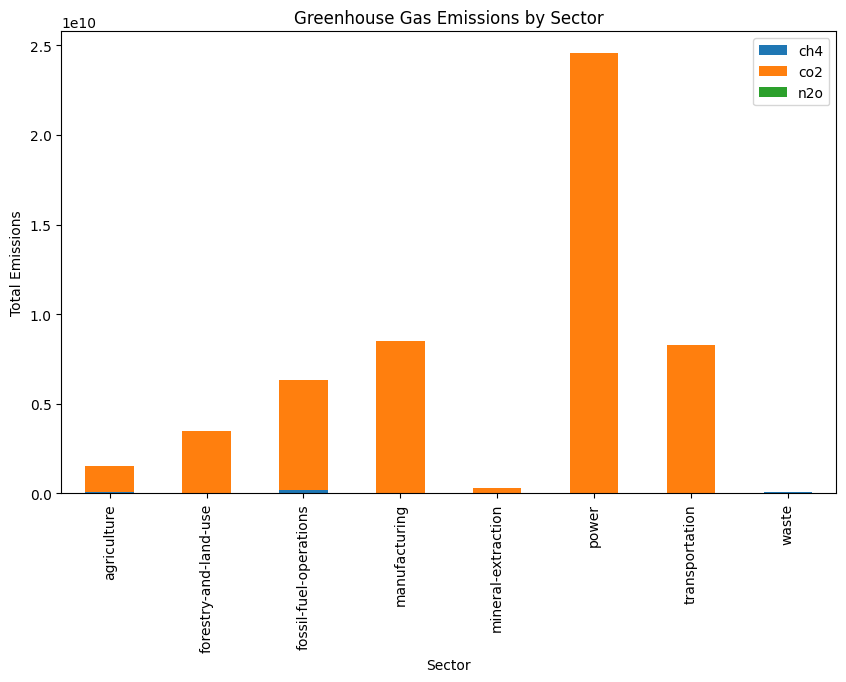

In [ ]:
grouped=concat_df1.groupby('sector')[['ch4', 'co2', 'n2o']].sum()

grouped.plot(kind='bar',stacked=True,figsize=(10, 6))
plt.title('Greenhouse Gas Emissions by Sector')
plt.xlabel('Sector')
plt.ylabel('Total Emissions')


- It seems that the power sector contributes most to greenhousegas emissions, overwhelmingly. I will try to analyze the data for the power sector, and find if there are any interesting facts or signals so that we can find ways to decrease emissions, or make some other contributions.

## Power sector data Analysis

In [ ]:
power=read_climatetrace(sectors='power')
power

,Id,Name,Country,Sector,AssetType,Activity,ActivityUnits,Capacity,CapacityFactor,CapacityUnits,...,EmissionsFactorUnits,n2o,co2,ch4,co2e_20yr,co2e_100yr,gas,year,lat,lon
0,25452242,Taichung power station,TWN,electricity-generation,"coal, oil",36702000.0,MWh,5834.0,0.718,MW,...,field_not_modeled,NaN,NaN,NaN,NaN,NaN,n2o,2021,24.2150,120.4790
1,25452242,Taichung power station,TWN,electricity-generation,"coal, oil",36702000.0,MWh,5834.0,0.718,MW,...,T of CO2 per MWh,NaN,33602000.0,NaN,NaN,NaN,co2,2021,24.2150,120.4790
2,25452242,Taichung power station,TWN,electricity-generation,"coal, oil",36702000.0,MWh,5834.0,0.718,MW,...,field_not_modeled,NaN,NaN,NaN,NaN,NaN,ch4,2021,24.2150,120.4790
3,25452242,Taichung power station,TWN,electricity-generation,"coal, oil",36702000.0,MWh,5834.0,0.718,MW,...,None,NaN,NaN,NaN,33602000.0,NaN,co2e_20yr,2021,24.2150,120.4790
4,25452242,Taichung power station,TWN,electricity-generation,"coal, oil",36702000.0,MWh,5834.0,0.718,MW,...,None,NaN,NaN,NaN,NaN,33602000.0,co2e_100yr,2021,24.2150,120.4790
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48613,25456303,Florence Mill,USA,electricity-generation,biomass,0.0,MWh,0.0,NaN,MW,...,field_not_modeled,NaN,NaN,NaN,NaN,NaN,n2o,2022,34.1533,-79.5586
48614,25456303,Florence Mill,USA,electricity-generation,biomass,0.0,MWh,0.0,NaN,MW,...,T of CO2 per MWh,NaN,0.0,NaN,NaN,NaN,co2,2022,34.1533,-79.5586
48615,25456303,Florence Mill,USA,electricity-generation,biomass,0.0,MWh,0.0,NaN,MW,...,field_not_modeled,NaN,NaN,NaN,NaN,NaN,ch4,2022,34.1533,-79.5586
48616,25456303,Florence Mill,USA,electricity-generation,biomass,0.0,MWh,0.0,NaN,MW,...,None,NaN,NaN,NaN,0.0,NaN,co2e_20yr,2022,34.1533,-79.5586


- Let's first look at the summary statistics of the data. It seems that columns of n2o and ch4 are meaningless, and co2e_20yr and co2e_100yr give the exact smae information with co2. I'll only leave observations with *gas=='co2'* and drop the other emission columns.

In [ ]:
power.describe()

,Id,Activity,Capacity,CapacityFactor,EmissionsFactor,n2o,co2,ch4,co2e_20yr,co2e_100yr,year,lat,lon
count,8.103000e+04,8.103000e+04,81030.000000,76700.000000,15264.000000,0.0,1.620600e+04,0.0,1.620600e+04,1.620600e+04,81030.000000,81030.000000,81030.000000
mean,2.545315e+07,1.992116e+06,524.944774,0.384992,0.676890,NaN,1.514211e+06,NaN,1.514211e+06,1.514211e+06,2021.501913,30.435405,12.323019
std,2.448180e+03,3.323103e+06,765.139854,0.159997,0.270836,NaN,2.919694e+06,NaN,2.919694e+06,2.919694e+06,0.499999,20.379210,86.047625
min,2.544885e+07,0.000000e+00,0.000000,0.000000,0.143000,NaN,0.000000e+00,NaN,0.000000e+00,0.000000e+00,2021.000000,-52.896600,-179.133800
25%,2.545104e+07,1.690000e+05,64.000000,0.302000,0.450000,NaN,9.600000e+04,NaN,9.600000e+04,9.600000e+04,2021.000000,23.727700,-78.745300
50%,2.545317e+07,6.735000e+05,220.000000,0.358000,0.623000,NaN,4.185000e+05,NaN,4.185000e+05,4.185000e+05,2022.000000,35.376150,18.496200
75%,2.545524e+07,2.409000e+06,684.000000,0.496000,0.897000,NaN,1.410000e+06,NaN,1.410000e+06,1.410000e+06,2022.000000,42.147200,100.572600
max,2.545739e+07,3.670200e+07,8898.000000,1.000000,2.435000,NaN,3.377400e+07,NaN,3.377400e+07,3.377400e+07,2022.000000,71.292000,179.388700


In [ ]:
power=power[power['gas']=='co2'].drop(columns=['n2o','ch4','co2e_20yr','co2e_100yr'])

- I asked Gemini if there are ways to improve my data, or points that I should be aware of. (I used my own API key)

In [ ]:
model=genai.GenerativeModel('gemini-1.5-flash')
chat=model.start_chat(history=[])
response=model.generate_content([f"This is a data of electricity-generation powerplants {power}. Can you give appropriate ways to clean up the data by handling outliers or anomalies considering information of GHG emissions monitering?"])
response.resolve()

In [ ]:
to_markdown(response.text)

> This data looks interesting! Let's discuss how to clean it up for GHG emissions monitoring. Here's a breakdown of potential issues and cleaning strategies:
> 
> **1. Missing Values (NaN):**
> 
> * **Issue:** You have missing values (NaN) in 'CapacityFactor' and 'EmissionsFactor' for power plants with 0 capacity. This makes sense as these plants likely aren't operational.
> * **Solution:**  
>     * **Leave as is:** If you are focusing on operational power plants, filter out rows with 0 capacity.
>     * **Impute:**  If you want to include these plants, you could explore imputation techniques like:
>         * **Mean/Median Imputation:** Replace NaN values with the mean or median of the column.
>         * **K-Nearest Neighbors:** Find similar power plants and use their values.
>         * **Model-Based Imputation:** Use a statistical model to predict missing values. 
> 
> **2.  Outliers in Capacity:**
> 
> * **Issue:** Power plant capacity (in MW) can vary greatly. A few extremely large plants might skew the data.
> * **Solution:**
>     * **Visualize:** Create a box plot or histogram of capacity. This helps identify outliers visually.
>     * **IQR Method:** Calculate the interquartile range (IQR) and remove values outside 1.5 times the IQR from the median.
>     * **Domain Expertise:** Consult with energy experts to determine if outlier capacities are realistic or represent errors.
> 
> **3. Outliers in Capacity Factor:**
> 
> * **Issue:** Capacity factor represents the actual output as a percentage of potential output. Values outside a reasonable range (e.g., 0-100%) could be errors. 
> * **Solution:**
>     * **Visualization:** Use a box plot or histogram to identify potential outliers.
>     * **Domain Expertise:**  Consulting with experts will help determine if outlier values are realistic (e.g., planned maintenance, unusual weather).
> 
> **4. Inconsistent Emissions Factors:**
> 
> * **Issue:**  Ensure all emissions factors are measured in the same units ("T of CO2 per MWh" in your data).  If you have other units (e.g., kg CO2/kWh), you'll need to convert them. 
> * **Solution:** Standardize all emissions factors to "T of CO2 per MWh" for consistent analysis.
> 
> **5.  Year Consistency:**
> 
> * **Issue:**  Make sure all data points are from the same year to avoid comparing apples and oranges. 
> * **Solution:**  
>     * **Filter:** If you only need data from a specific year, filter the dataset accordingly.
>     * **Time Series Analysis:**  If you need to analyze data over time, you might need to consider time series techniques to account for year-to-year variations.
> 
> **6. Data Accuracy:**
> 
> * **Issue:** Always consider the source of the data and its potential accuracy. Errors or inconsistencies can exist.
> * **Solution:**  
>     * **Cross-Reference:** If possible, cross-check the data with other sources to ensure reliability.
>     * **Data Validation:**  Use data validation methods to identify potential anomalies or errors.
> 
> **Additional Tips:**
> 
> * **Consider Data Visualization:** Box plots, histograms, scatter plots, and maps can help you identify potential outliers and relationships in your data.
> * **Domain Expertise is Key:** Consult with experts in the energy industry or GHG emissions monitoring to make informed decisions about data cleaning.
> * **Document Your Cleaning Steps:**  Record all cleaning steps and assumptions to ensure reproducibility and accountability.
> 
> **Example Code Snippet (Python - pandas):**
> 
> ```python
> import pandas as pd
> 
> # Load your data
> df = pd.read_csv('powerplants_data.csv')
> 
> # Filter for operational plants
> df = df[df['Capacity'] > 0]
> 
> # Remove outliers in Capacity using IQR method
> Q1 = df['Capacity'].quantile(0.25)
> Q3 = df['Capacity'].quantile(0.75)
> IQR = Q3 - Q1
> df = df[~((df['Capacity'] < (Q1 - 1.5 * IQR)) | (df['Capacity'] > (Q3 + 1.5 * IQR)))]
> 
> # ... (Continue with other cleaning steps as needed) 
> ```
> 
> Remember to adapt these techniques to your specific dataset and analytical goals.  The ultimate goal is to achieve a clean and reliable dataset for accurate GHG emissions monitoring! 


### Missing Values

- Looking at the patterns of the missing values by visualizing them, as Gemini said, it seems that these missing values come from non-operating powerplants.(Distributing at the bottom side of the dataset) We can filter the non-operating plants. (Instead of using the 'Capacity'>0, I used 'Activity'>0 which would more accurate to filter out non-operating plants.)

<Axes: >

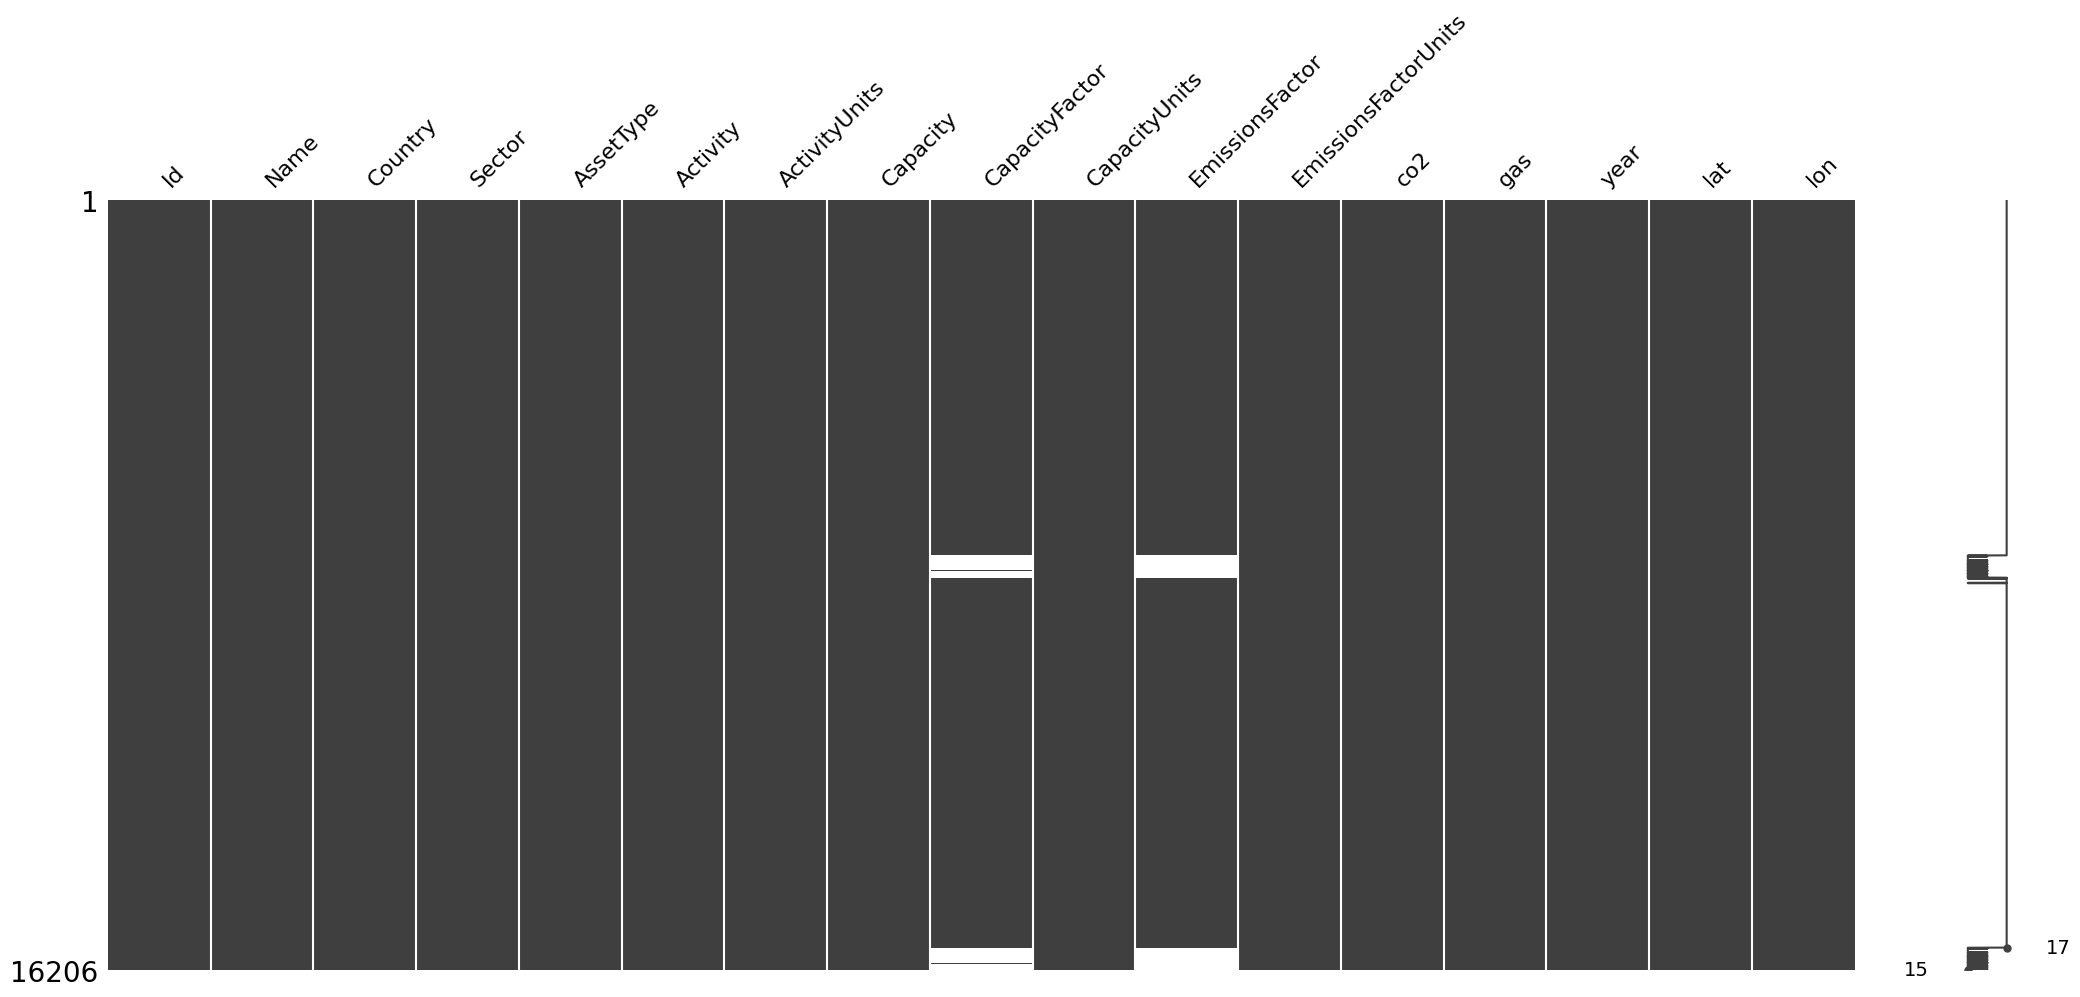

In [ ]:
import missingno as msno

msno.matrix(power)

In [ ]:
power=power[power['Activity']>0]

In [ ]:
power.isna().sum()

,0
Id,0
Name,0
Country,0
Sector,0
AssetType,0
Activity,0
ActivityUnits,0
Capacity,0
CapacityFactor,0
CapacityUnits,0


### Outliers of Capacity

- As Gemini pointed out, there are some noticeable outliers in the dataset. Instead of just filtering them out, I will find ways to fix these outliers (they may be errors) to the right value. I used my own openai apikey, as well.
- Especially, as the Capacity value is a significant part of calculating the activity of each plant, and thus calculating the emissions of each plant, wrong capacity values will lead to big errors in emission. If we look up for the capacity of the plant that has the maximum value of capacity in the dataset(which is an outlier), Surgut GRES-2 power station, the capacity value is somewhat different. We should modify these to the correct information.

---

- I'll first use 'Surgut GRES-2 power station' as an example, to write better questions so that I could get better responses.

In [ ]:
power.sort_values(by='Capacity',ascending=False).head(4)

,Id,Name,Country,Sector,AssetType,Activity,ActivityUnits,Capacity,CapacityFactor,CapacityUnits,EmissionsFactor,EmissionsFactorUnits,co2,gas,year,lat,lon
13,25452360,Surgut GRES-2 power station,RUS,electricity-generation,gas,34920000.0,MWh,8898.0,0.448,MW,0.885,T of CO2 per MWh,30900000.0,co2,2021,61.2794,73.4889
14,25452360,Surgut GRES-2 power station,RUS,electricity-generation,gas,35622000.0,MWh,8898.0,0.457,MW,0.885,T of CO2 per MWh,31521000.0,co2,2022,61.2794,73.4889
746,25450583,Jebel Ali M Power and Desalination Station,ARE,electricity-generation,"gas, oil, other_fossil",21386000.0,MWh,8285.0,0.295,MW,0.580,T of CO2 per MWh,12414000.0,co2,2021,25.0493,55.1116
751,25450583,Jebel Ali M Power and Desalination Station,ARE,electricity-generation,"gas, oil, other_fossil",21386000.0,MWh,8285.0,0.295,MW,0.580,T of CO2 per MWh,12414000.0,co2,2022,25.0493,55.1116


In [ ]:
%%capture
!pip install openai

- I used my own openai api_key, and asked gpt to return the Capacity of the facility in MW, with a citation, in a dictionary form so I could access to these information in the response easily.

In [ ]:
from google.colab import userdata
from openai import OpenAI
import ast

OPENAI_API_KEY=userdata.get('openai_apikey')
client=OpenAI(api_key=OPENAI_API_KEY)

In [ ]:
facility_name='Surgut GRES-2 power station'
facility_country='Russia'
MODEL="gpt-4o"

In [ ]:
response=client.chat.completions.create(
    model=MODEL,
    messages=[
        {'role':'system',
         'content':'''
         You will  be asked to identify the the capacity of an electricity-generation facility,
         like power station. Capacity is the capacity of the entity producing emissions, in the unit MW.

         Return the capacity of the entity producing emissions in MW, without the units, only the number.
         With only citations included additionally, provide a valid citation. Return this in a dictionary form.

         Here is an example of the expected dictionary form:

         {'Capacity':5000,'citation':'https://www.google.com'}

         '''},
        {'role':'user',
         'content':f'''
         Find the most recent information on Capacity of the entity producing emissions for the {facility_name} powerplant,
         based in {facility_country}.
         '''}
    ]
)

In [ ]:
response.choices[0].message.content

"{'Capacity':5700, 'citation':'https://www.gem.wiki/Surgut_GRES-2_power_station'}"

- Since the original value was 8898, we can know that there may be more errors in the Capacity column. We can correct them using a function.

---

- Instead of going all over the capacity values, we can review only the outliers by making a filtered dataframe containing the outliers. I used the IQR method to detect outliers, and the function **outliers()** receives the df, column, and the threshold. Based on the threshold, we can filter out observations which are out of the normal range. The function will return a filtered dataframe.


---

- Next, the **get_capacity** function receives the facility_name and facility_country as arguments, and returns the response of chat gpt, which contains information of the facility capacity.



In [ ]:
def outliers(df,column,threshold):
  Q1=df[column].quantile(0.25)
  Q3=df[column].quantile(0.75)
  IQR=Q3-Q1
  lower_bound=Q1-threshold*IQR
  upper_bound=Q3+threshold*IQR
  outliers=df[(df[column]<lower_bound) | (df[column]>upper_bound)]
  return outliers

In [ ]:
def get_capacity(facility_name,facility_country):
  """
  Gets the capacity of an electricity-generation facility using an LLM.

  Args:
    facility_name: Name of the facility.
    facility_country: Country of the facility.

  Returns:
    A dictionary containing the capacity of the facility and a citation.
  """
  response=client.chat.completions.create(
    model=MODEL,
    messages=[
        {'role':'system',
         'content':'''
         You will  be asked to identify the the capacity of an electricity-generation facility,
         like power station. Capacity is the capacity of the entity producing emissions, in the unit MW.

         Return the capacity of the entity producing emissions in MW, without the units, only the number.
         With only citations included additionally, provide a valid citation. Return this in a dictionary form.

         Here is an example of the expected dictionary form:

         {'Capacity':5000,'citation':'https://www.google.com'}

         '''},
        {'role':'user',
         'content':f'''
         Find the most recent information on Capacity of the entity producing emissions for the {facility_name} powerplant,
         based in {facility_country}.
         '''}
    ]
)
  return ast.literal_eval(response.choices[0].message.content)

#### Test with power data

- I did a test with a few observations, by setting the threshold quite high (I didn't want to run down my usage limits). First I stored the outlier observations in **power_outliers**, and stored the response of chat gpt(obtained by the get_capacity() function) in a list format named **my_list**.

In [ ]:
power_22=power[power['year']==2022]

In [ ]:
power_outliers=outliers(power_22,'Capacity',10)
power_outliers

,Id,Name,Country,Sector,AssetType,Activity,ActivityUnits,Capacity,CapacityFactor,CapacityUnits,EmissionsFactor,EmissionsFactorUnits,co2,gas,year,lat,lon
14,25452360,Surgut GRES-2 power station,RUS,electricity-generation,gas,35622000.0,MWh,8898.0,0.457,MW,0.885,T of CO2 per MWh,31521000.0,co2,2022,61.2794,73.4889
422,25451996,Rabigh power plant,SAU,electricity-generation,"oil, other_fossil",16007000.0,MWh,7280.0,0.251,MW,0.972,T of CO2 per MWh,15555000.0,co2,2022,22.6694,39.0365
751,25450583,Jebel Ali M Power and Desalination Station,ARE,electricity-generation,"gas, oil, other_fossil",21386000.0,MWh,8285.0,0.295,MW,0.580,T of CO2 per MWh,12414000.0,co2,2022,25.0493,55.1116


In [ ]:
my_list=[get_capacity(power_outliers['Name'].values[i],power_outliers['Country'].values[i]) for i in range(len(power_outliers))]

In [ ]:
my_list

[{'Capacity': 5680,
  'citation': 'https://www.uniper.energy/russia/en/surgutskaya-gres-2'},
 {'Capacity': 3600,
  'citation': 'https://www.power-technology.com/marketdata/rabigh-power-plant-saudi-arabia/'},
 {'Capacity': 2060,
  'citation': 'https://www.dewa.gov.ae/en/customer/innovation/sustainable-energy/jebel-ali-power-station'}]

#### Final Function for editing Capacity Outliers

- Now, we can make a function that corrects the Capacity information in the original data. I named the function **correct_capacity**, receiving the original df and the threshold. The function locally stores the outliers using **outliers()** function in the outlier_df.
- Looping through the observations of the outlier_df, we first set the facility_name and facility_country by extracting values from the dataframe, and plug it into the get_capacity() function. Then, I changed the values of that observation into the values returned by the function by assigning conditions of the specific facility row.
- After the loop, we can receive the modified dataframe!


In [ ]:
def correct_capacity(df,threshold):
  """
  Corrects the capacity information of outliers in the dataframe.

  Args:
    df: The dataframe containing the capacity information.
    threshold: The threshold for outlier detection.

  Returns:
    The dataframe with corrected capacity information on outliers.
  """
  outlier_df=outliers(df,'Capacity',threshold)
  for i in range(len(outlier_df)):
    facility_name=outlier_df['Name'].values[i]
    facility_country=outlier_df['Country'].values[i]
    df.loc[(df['Name']==facility_name) & (df['Country']==facility_country),'Capacity']=get_capacity(facility_name,facility_country)['Capacity']
  return df

- I tested whether the function works, and it successfully reflected the changes!

In [ ]:
corrected_df=correct_capacity(power_22,10)

In [ ]:
corrected_df[corrected_df['Name']=='Surgut GRES-2 power station']

,Id,Name,Country,Sector,AssetType,Activity,ActivityUnits,Capacity,CapacityFactor,CapacityUnits,EmissionsFactor,EmissionsFactorUnits,co2,gas,year,lat,lon
14,25452360,Surgut GRES-2 power station,RUS,electricity-generation,gas,35622000.0,MWh,5600.0,0.457,MW,0.885,T of CO2 per MWh,31521000.0,co2,2022,61.2794,73.4889


**- I just made a function, without modifying the whole dataframe, because I'm not using the Capacity information afterwards - it was just a step to improve the electricity-generation emissions dataset.**

- Additionally, I checked whether inconsistency exists in capacity units or emissions factors units. There is only 1 unique value for the units, so we're good to go!

In [ ]:
power.CapacityUnits.unique()

array(['MW'], dtype=object)

In [ ]:
power.EmissionsFactorUnits.unique()

array(['T of CO2 per MWh'], dtype=object)

### Decrease rate / Decrease of emissions by countries

- Now, let's compare the emissions of 2021 and 2022 by country, and see if there are any interesting facts. if there are countries that achieved a large decrease in their emissions, we can identify them and get lessons.


---

- I first made a new dataset, **country_emissions** by grouping the original dataset by 'Country' and 'year', and summing the 'co2', so I could obtain the information of the sum of co2 emissions of each year, for each country.
- Next, I separated the dataset into two datasets, so I could merge the data of 2021 emissions and 2022 emissions to a same observation(row).
- Before merging them, I filtered out observations that have the 'co2' value as 0 in year 2021, because they are going to be used in the denominator.
- We can merge the two dataframes on the column 'Country', and now, **emissions** will contain the country, and the 2021 & 2022 emissions of that country.
- I added a column of 'decrease_rate' by dividing the reduction of emissions between 2021 and 2022 into emissions of 2021, and 'decrease_value' that is the actual quantity of reduction in co2 emissions. *(This means that if the decrease_value is positive, the country had a decline in their emissions.)*


In [ ]:
country_emissions=power[['Country','year','co2']].groupby(['Country','year']).sum('co2').reset_index()

emissions_2021=country_emissions[country_emissions['year']==2021][['Country','co2']]
emissions_2022=country_emissions[country_emissions['year']==2022][['Country','co2']]

In [ ]:
emissions_2021=emissions_2021[emissions_2021['co2']>0]

In [ ]:
emissions=emissions_2021.merge(emissions_2022,on='Country')
emissions.columns=['Country','co2_2021','co2_2022']
emissions['decrease_rate']=(emissions['co2_2021']-emissions['co2_2022'])/emissions['co2_2021']
emissions['decrease_value']=emissions['co2_2021']-emissions['co2_2022']

- Now, to plot a choropleth map based on 'decrease_rate', I first called the naturalearth_lowres data from geopandas package. Then merged the emissions data on country name forming a new dataframe, **world_emissions**.


---

- Based on the world_emissions dataframe, I colored the countries on the column 'decrease_rate'.

In [ ]:
world=geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

world_emissions=world.merge(emissions,left_on='iso_a3',right_on='Country')

<ipython-input-9-c26c6a630654>:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world=geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))


Text(0.5, 1.0, 'Decrease rate of co2 emissions by countries')

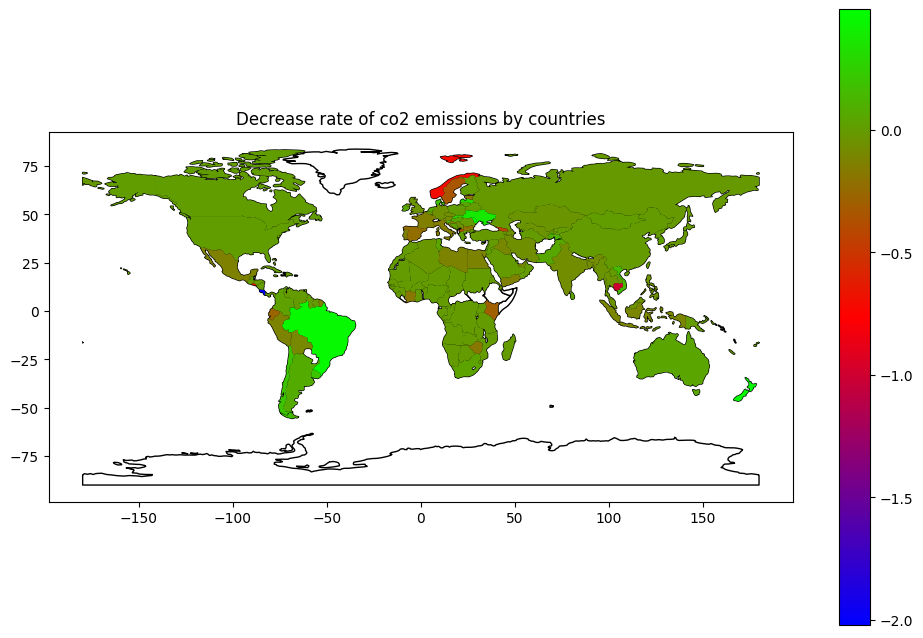

In [ ]:
fig,ax=plt.subplots(figsize=(12,8))

world.plot(
    ax=ax,color='white',edgecolor='black'
)
world_emissions.plot(
    ax=ax,column='decrease_rate',cmap='brg',legend=True
)
plt.title('Decrease rate of co2 emissions by countries')

- Also, let's look at the dataframe sorted in descending orders by 'decrease_rate.

In [ ]:
world_emissions.sort_values(by='decrease_rate',ascending=False)

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,Country,co2_2021,co2_2022,decrease_rate,decrease_value
97,2657637.0,Europe,Moldova,MDA,11968,"POLYGON ((26.61934 48.22073, 26.85782 48.36821...",MDA,1129000.0,572000.0,0.493357,557000.0
113,4917000.0,Oceania,New Zealand,NZL,206928,"MULTIPOLYGON (((176.88582 -40.06598, 176.50802...",NZL,5194000.0,2758000.0,0.469003,2436000.0
22,211049527.0,South America,Brazil,BRA,1839758,"POLYGON ((-53.37366 -33.76838, -53.65054 -33.2...",BRA,84551000.0,45507000.0,0.461780,39044000.0
93,44385155.0,Europe,Ukraine,UKR,153781,"POLYGON ((32.15944 52.06125, 32.41206 52.28869...",UKR,39596000.0,24412000.0,0.383473,15184000.0
100,1912789.0,Europe,Latvia,LVA,34102,"POLYGON ((27.28818 57.47453, 27.77002 57.24426...",LVA,710000.0,489000.0,0.311268,221000.0
...,...,...,...,...,...,...,...,...,...,...,...
122,3720382.0,Asia,Georgia,GEO,17477,"POLYGON ((39.95501 43.43500, 40.07696 43.55310...",GEO,1148000.0,1650000.0,-0.437282,-502000.0
30,6453553.0,North America,El Salvador,SLV,27022,"POLYGON ((-89.35333 14.42413, -89.05851 14.340...",SLV,614000.0,990000.0,-0.612378,-376000.0
17,5347896.0,Europe,Norway,NOR,403336,"MULTIPOLYGON (((15.14282 79.67431, 15.52255 80...",NOR,181000.0,309000.0,-0.707182,-128000.0
74,16486542.0,Asia,Cambodia,KHM,27089,"POLYGON ((102.58493 12.18659, 102.34810 13.394...",KHM,4025000.0,8085000.0,-1.008696,-4060000.0


- There are countries that made a significant decrease in their electricity generation co2 emissions. Moldova, New Zealand, Brazil had a decrease of over 40% of their emissions. These countries had a big reduction on their emissions, even the overall worldwide trend had an increase in emissions.



---

- Let's also look at the trends of individual powerplants and see whether they are consistent with results above.
- I separated the power dataset by years, power_2021 and power_2022.
- I filtered out observations that have 0 values for co2 emissions in 2021 to avoid syntax errors.
- Next, we can merge the two year datasets and get the data **power_by_year**. I renamed the columns so their meanings are more clearly understood.
- I added a column of 'decrease_rate' by dividing the reduction of emissions between 2021 and 2022 into emissions of 2021, and 'decrease_value' that is the actual quantity of reduction in co2 emissions.

In [ ]:
power_2021=power[power['year']==2021][['Id','Name','Capacity','Country','AssetType','co2','lat','lon']]
power_2022=power[power['year']==2022][['Id','Name','co2']]

In [ ]:
power_2021=power_2021[power_2021['co2']>0]

In [ ]:
power_by_year=power_2021.merge(power_2022,on=['Id','Name'])
power_by_year.columns=['Id','Name','Capacity','Country','AssetType','co2_2021','lat','lon','co2_2022']

power_by_year['decrease_value']=power_by_year['co2_2021']-power_by_year['co2_2022']
power_by_year['decrease_rate']=(power_by_year['co2_2021']-power_by_year['co2_2022'])/power_by_year['co2_2021']

In [ ]:
power_by_year

,Id,Name,Capacity,Country,AssetType,co2_2021,lat,lon,co2_2022,decrease_value,decrease_rate
0,25452242,Taichung power station,5834.0,TWN,"coal, oil",33602000.0,24.2150,120.4790,32698000.0,904000.0,0.026903
1,25451253,Taean power station,6480.0,KOR,"coal, other_fossil",33774000.0,36.9033,126.2343,32237000.0,1537000.0,0.045508
2,25452360,Surgut GRES-2 power station,8898.0,RUS,gas,30900000.0,61.2794,73.4889,31521000.0,-621000.0,-0.020097
3,25451254,Dangjin power station,6040.0,KOR,coal,32380000.0,37.0551,126.5122,30915000.0,1465000.0,0.045244
4,25451405,Togtoh power station,6720.0,CHN,coal,28631000.0,40.1952,111.3589,27976000.0,655000.0,0.022877
...,...,...,...,...,...,...,...,...,...,...,...
7476,25451924,CMPC power station,3.0,BRA,"biomass, oil",3000.0,-30.1334,-51.3181,1000.0,2000.0,0.666667
7477,25451281,Petrokemija Kutina power station,58.0,HRV,oil,2000.0,45.4713,16.7923,1000.0,1000.0,0.500000
7478,25452558,Kakira Sugar power station,2.0,UGA,"biomass, oil",1000.0,0.4400,33.2000,1000.0,0.0,0.000000
7479,25451330,<unknown plant name>,22.0,SWE,gas,1000.0,55.7212,13.1555,1000.0,0.0,0.000000


- We can extract plants with the highest emission decrease rate and store them to another dataframe. I extracted the top 100 plants, into **top_decrease**
- Next, I converted the dataframe into a geopandas dataframe, so I could plot the plants, and plotted them on the world map differing their colors on the decrease_rate column.

In [ ]:
top_decrease=power_by_year.sort_values(by='decrease_rate',ascending=False).head(100)

In [ ]:
gdf=geopandas.GeoDataFrame(top_decrease,geometry=geopandas.points_from_xy(top_decrease.lon,top_decrease.lat))

Text(0.5, 1.0, 'Individual Powerplants with Top Emission Decrease Rate')

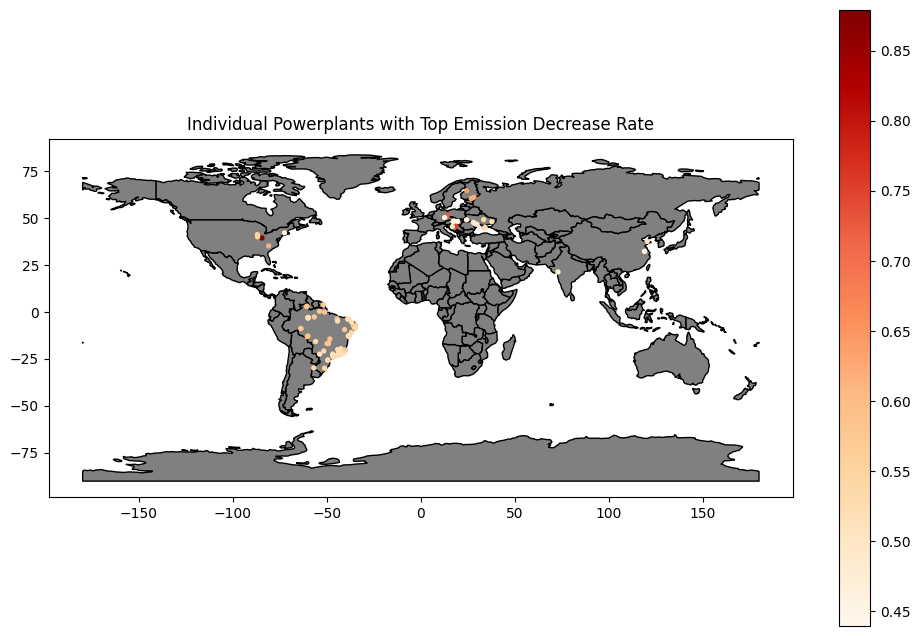

In [ ]:
fig,ax=plt.subplots(figsize=(12,8))

world.plot(
    ax=ax,color='grey',edgecolor='black'
)
gdf.plot(
    ax=ax,column='decrease_rate',cmap='OrRd',legend=True,markersize=8
)
plt.title('Individual Powerplants with Top Emission Decrease Rate')

- Through the plot, we can see that there are fairly many plants in Brazil which had a high decrease rate, also in Moldova and Ukrania, some in Europe and USA.
- But, we can notice that there are ***no plants plotted in New Zealand***, even it ranked in top of the countries with its decrease rate. Maybe we should look if there are some more errors in the dataset, and come back to this topic.

#### Fixing errors/gaps of the dataset - Unmatching IDs & unknown names

##### Unmatching IDs
- Let's take a look at the data to see why some powerplants of New Zealand were excluded. In the original dataframe, there were 8 powerplants in New Zealand, but in the adjusted dataframe, we can see only 7 powerplants.
- The Id of the 'Huntly power station' seems to be changed, or there might have been an error inserting the id. To get access to more perfect data, we should find these mismatched IDs, and modify them.
- Also, as I tried to merge on the Name column of the powerplants of 2021 and 2022, I found some plants missing their name - as \<unknown plant name\>. These imperfect information may cause confusion later in the process of data analysis or policy formation.
- The IDs are an internal Climate TRACE identifier, which cannot be found in the internet, so I'll modify them by comparing the 2021 and 2022 data. For the unknown plant names, I will try to fill them through LLMs.

In [ ]:
power[power['Country']=='NZL']

,Id,Name,Country,Sector,AssetType,Activity,ActivityUnits,Capacity,CapacityFactor,CapacityUnits,EmissionsFactor,EmissionsFactorUnits,co2,gas,year,lat,lon
14963,25452354,Stratford power station,NZL,electricity-generation,gas,2422000.0,MWh,587.0,0.471,MW,0.419,T of CO2 per MWh,1016000.0,co2,2021,-39.3305,174.3197
29619,25450306,Glenbrook power station,NZL,electricity-generation,"gas, other_fossil",348000.0,MWh,110.0,0.361,MW,0.647,T of CO2 per MWh,225000.0,co2,2021,-37.2065,174.7245
30216,25454300,McKee power station,NZL,electricity-generation,gas,413000.0,MWh,100.0,0.471,MW,0.513,T of CO2 per MWh,212000.0,co2,2021,-39.0976,174.3360
30252,25455561,Junction Road power station,NZL,electricity-generation,gas,413000.0,MWh,100.0,0.471,MW,0.513,T of CO2 per MWh,212000.0,co2,2021,-39.1168,174.1036
33801,25453308,Whirinaki power station,NZL,electricity-generation,oil,212000.0,MWh,156.0,0.155,MW,0.604,T of CO2 per MWh,128000.0,co2,2021,-39.3827,176.8879
35445,25451222,Whareroa power station,NZL,electricity-generation,"gas, oil",289000.0,MWh,70.0,0.471,MW,0.367,T of CO2 per MWh,106000.0,co2,2021,-39.6099,174.2986
38222,25454626,Te Rapa,NZL,electricity-generation,gas,182000.0,MWh,44.0,0.472,MW,0.368,T of CO2 per MWh,67000.0,co2,2021,-37.7165,175.2168
48420,25450715,Huntly power station,NZL,electricity-generation,"coal, gas, other_fossil",2994000.0,MWh,933.0,0.366,MW,1.078,T of CO2 per MWh,3228000.0,co2,2021,-37.5445,175.1488
15196,25452354,Stratford power station,NZL,electricity-generation,gas,2371000.0,MWh,587.0,0.461,MW,0.419,T of CO2 per MWh,994000.0,co2,2022,-39.3305,174.3197
17091,25450716,Huntly power station,NZL,electricity-generation,"gas, other_fossil, coal",1495000.0,MWh,933.0,0.183,MW,0.553,T of CO2 per MWh,827000.0,co2,2022,-37.5445,175.1488


In [ ]:
power_by_year[power_by_year['Country']=='NZL']

,Id,Name,Country,AssetType,co2_2021,lat,lon,co2_2022,decrease_value,decrease_rate
2484,25452354,Stratford power station,NZL,gas,1016000.0,-39.3305,174.3197,994000.0,22000.0,0.021654
4916,25450306,Glenbrook power station,NZL,"gas, other_fossil",225000.0,-37.2065,174.7245,223000.0,2000.0,0.008889
5015,25454300,McKee power station,NZL,gas,212000.0,-39.0976,174.3360,207000.0,5000.0,0.023585
5021,25455561,Junction Road power station,NZL,gas,212000.0,-39.1168,174.1036,207000.0,5000.0,0.023585
5609,25453308,Whirinaki power station,NZL,oil,128000.0,-39.3827,176.8879,131000.0,-3000.0,-0.023438
5881,25451222,Whareroa power station,NZL,"gas, oil",106000.0,-39.6099,174.2986,104000.0,2000.0,0.018868
6342,25454626,Te Rapa,NZL,gas,67000.0,-37.7165,175.2168,65000.0,2000.0,0.029851


- At first, I tried to resolve this error by merging on the 'Country' and 'Name', instead of using IDs. However it turned out that there were some observations with their 'Name' column as \<unknown plant name>, so it was unable to match the plans exactly through their names. These unknown plant names also may be gaps to getting the specific information or locations of powerplants, so we should deal with them too (I will do this in the next part)
- We have to essentially edit the unmatching IDs.

In [ ]:
power_2022=power[power['year']==2022][['Country','Name','co2']]
power_by_year_test=power_2021.merge(power_2022,on=['Country','Name'])
power_by_year_test.columns=['Id','Name','Country','AssetType','co2_2021','lat','lon','co2_2022']

power_by_year_test['decrease_rate']=(power_by_year_test['co2_2021']-power_by_year_test['co2_2022'])/power_by_year_test['co2_2021']
top_decrease_test=power_by_year_test.sort_values(by='decrease_rate',ascending=False).head(100)
top_decrease_test.head(5)

,Id,Name,Country,AssetType,co2_2021,lat,lon,co2_2022,decrease_rate
4760,25454024,<unknown plant name>,KOR,gas,3062000.0,36.9906,126.7141,6000.0,0.998040
185,25455967,<unknown plant name>,CHN,coal,12120000.0,44.8524,89.1959,51000.0,0.995792
4769,25455920,<unknown plant name>,KOR,"gas, other_fossil",1074000.0,35.9836,126.7307,6000.0,0.994413
184,25455967,<unknown plant name>,CHN,coal,12120000.0,44.8524,89.1959,68000.0,0.994389
183,25455967,<unknown plant name>,CHN,coal,12120000.0,44.8524,89.1959,80000.0,0.993399


- I made an empty dataframe to store the observations of the  unmatching ids(so that I could double check the results), and filtered out some duplicates of the 'Name' column so that there will be no confusion due to the same name, or \<unknown plant name>
- Looping through the power_2021_unique dataset, I stored the value of the 'Name' column in name, and compared the id of 2021 and 2022 by extracting rows through the name. If the id unmatches, I added that row into the unmatced_ids dataframe, and modified the 'Id' value of power_2021 to the Id_value of power_2022.

In [ ]:
unmatched_ids=pd.DataFrame()
power_2021_unique=power_2021.drop_duplicates(subset=['Name'])

for i in range(len(power_2021_unique)):
  name=power_2021_unique['Name'].values[i]
  id_2021=power_2021_unique[power_2021_unique['Name']==name]['Id'].values[0]
  try:
    id_2022=power_2022[power_2022['Name']==name]['Id'].values[0]
    if id_2021!=id_2022:
      unmatched_ids=pd.concat([unmatched_ids,power_2021_unique.iloc[[i]]],ignore_index=True)
      power_2021.loc[power_2021['Id']==id_2021,'Id']=id_2022
  except:
    continue

unmatched_ids

,Id,Name,Capacity,Country,AssetType,co2,lat,lon
0,25450612,IRU Elektrijaam power station,207.0,EST,"waste, gas",102000.0,59.4514,24.9246
1,25450507,Manzanillo (Manuel Álvarez Moreno) power station,2860.0,MEX,"gas, oil, other_fossil",6437000.0,19.0278,-104.3192
2,25450786,Vitória power station,213.0,PRT,"oil, gas, other_fossil",194000.0,32.6480,-16.9676
3,25457186,Jiangyin Cogen power station,50.0,CHN,coal,230000.0,31.8436,120.4103
4,25456375,Elkton,12.0,USA,"gas, oil",17000.0,38.3836,-78.6528
5,25456151,Medical Area Total Energy Plant,68.0,USA,"gas, oil",87000.0,42.3368,-71.1081
6,25455943,Jiulong Paper Mill power station,341.0,CHN,coal,1565000.0,23.0351,113.5364
7,25455901,West Burton power station,3620.0,GBR,"gas, coal, oil",4117000.0,53.3622,-0.8076
8,25455413,Qeshm (Ghadir) power station,340.0,IRN,gas,746000.0,26.9011,55.9111
9,25453499,Heris power station,310.0,IRN,gas,680000.0,38.2252,46.9629


- Seems there were 56 erros (or modifications) in the IDs.
- Let's check if the IDs really unmatch in the observations inside **unmatched_ids**, and yes, they seem to have unmatching IDs, even their name and location are the same!

In [ ]:
power[power['Name']=='Suomenoja power station']

,Id,Name,Country,Sector,AssetType,Activity,ActivityUnits,Capacity,CapacityFactor,CapacityUnits,EmissionsFactor,EmissionsFactorUnits,co2,gas,year,lat,lon
48385,25450912,Suomenoja power station,FIN,electricity-generation,"gas, other_fossil, coal",422000.0,MWh,290.0,0.166,MW,0.45,T of CO2 per MWh,190000.0,co2,2021,60.1497,24.7181
33175,25450913,Suomenoja power station,FIN,electricity-generation,"other_fossil, gas, coal",234000.0,MWh,290.0,0.092,MW,0.65,T of CO2 per MWh,152000.0,co2,2022,60.1497,24.7181


- Using the modified dataframe(power_2021, with the same name), we can plot the top powerplants of emission quantity decrease with the updated information.
- I did the same thing, and now we can see a point plotted in New Zealand!

In [ ]:
power_by_year_new=power_2021.merge(power_2022,on=['Id','Name'])
power_by_year_new.columns=['Id','Name','Capacity','Country','AssetType','co2_2021','lat','lon','co2_2022']

power_by_year_new['decrease_value']=power_by_year_new['co2_2021']-power_by_year_new['co2_2022']
power_by_year_new['decrease_rate']=(power_by_year_new['co2_2021']-power_by_year_new['co2_2022'])/power_by_year_new['co2_2021']

In [ ]:
top_decrease_new=power_by_year_new.sort_values(by='decrease_rate',ascending=False).head(100)

In [ ]:
gdf_new=geopandas.GeoDataFrame(top_decrease_new,geometry=geopandas.points_from_xy(top_decrease_new.lon,top_decrease_new.lat))

Text(0.5, 1.0, 'Individual Powerplants with Top Emission Decrease Rate')

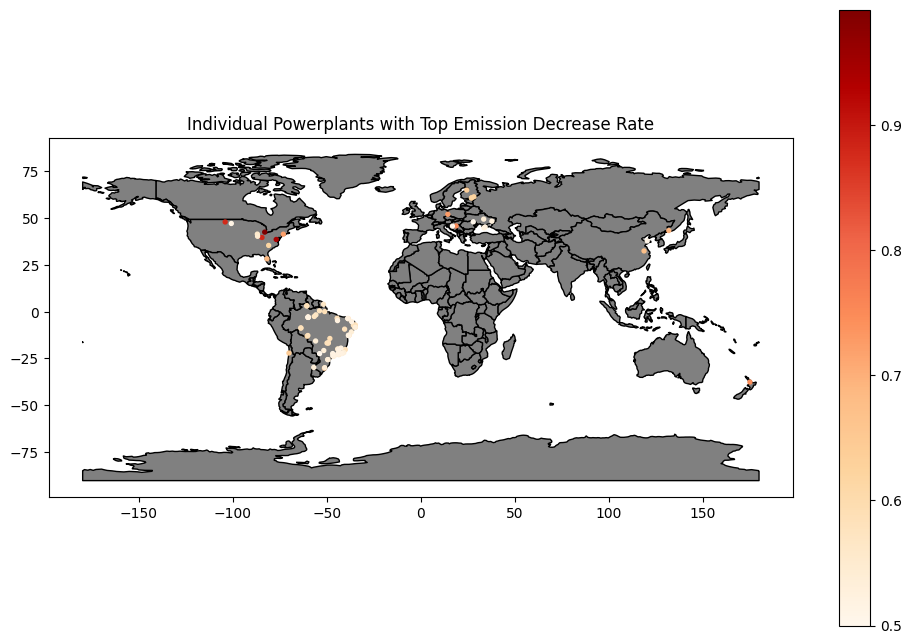

In [ ]:
fig,ax=plt.subplots(figsize=(12,8))

world.plot(
    ax=ax,color='grey',edgecolor='black'
)
gdf_new.plot(
    ax=ax,column='decrease_rate',cmap='OrRd',legend=True,markersize=8
)
plt.title('Individual Powerplants with Top Emission Decrease Rate')

- By plotting the powerplants which had the highest individual decrease rate, we can notice that they are creating clusters on the map.
- As seen before, Brazil made an overall decrease in their emissions throughout the country. Out of 84 of the powerplants in Brazil, 73 were in the top decrease plants.
- In case of New Zealand, it seems that there was a fairly big decrease in one power plant(The color of the plant plotted in New Zealand is relatively dark - meaning a high decrease rate), and this is 'Huntly power station' as we took a look while handling the unmatching IDs. We should take a look of this later.
- Also, there is a cluster of powerplants on East Europe. This may be related with the Russian invasion on Ukraine - maybe some issues on the price of natural gas? Let's identify this later also.

In [ ]:
print(f'# of powerplants in Brazil: {len(power_by_year_new[power_by_year_new["Country"]=="BRA"])}')
print(f'# of powerplants of top emission decrease in Brazil: {len(top_decrease_new[top_decrease_new["Country"]=="BRA"])}')

print(f'\n Average emission decrease rate of Brazil powerplant: {top_decrease_new[top_decrease_new["Country"]=="BRA"]["decrease_rate"].mean()}')

# of powerplants in Brazil: 84
# of powerplants of top emission decrease in Brazil: 73

 Average emission decrease rate of Brazil powerplant: 0.5535436189488547




---



##### Function for fixing unmatching IDs
- I made a function **modify_ids**, that can be applied to the whole dataframe of ClimateTrace, fixing mismatched IDs, by receiving the target dataset.
- Just by spliting the data into 2021 and 2022 and modifying the 2021 ids, then concatenating them, we can obtain the modified dataset with the unmatching ids handled.

In [ ]:
def modify_ids(df):
  """
  Modifies mismatched IDs in the dataframe.

  Args:
    df: The dataframe that needs modification

  Returns:
    The modified dataframe with corrected IDs.
  """
  df_2021=df[df['year']==2021]
  df_2022=df[df['year']==2022]

  df_2021_unique=df_2021.drop_duplicates(subset=['Name'])

  for i in range(len(df_2021_unique)):
    name=df_2021_unique['Name'].values[i]
    id_2021=df_2021_unique[df_2021_unique['Name']==name]['Id'].values[0]
    try:
      id_2022 = df_2022[df_2022['Name']==name]['Id'].values[0]
      if id_2021!=id_2022:
        df_2021.loc[df_2021['Id']==id_2021,'Id']=id_2022
    except:
      continue
  df=pd.concat([df_2021,df_2022],ignore_index=True)
  return df

In [ ]:
power_new=modify_ids(power)

- We can confirm that the IDs are successfully modified!

In [ ]:
power[power['Name']=='Suomenoja power station']

,Id,Name,Country,Sector,AssetType,Activity,ActivityUnits,Capacity,CapacityFactor,CapacityUnits,EmissionsFactor,EmissionsFactorUnits,co2,gas,year,lat,lon
48385,25450912,Suomenoja power station,FIN,electricity-generation,"gas, other_fossil, coal",422000.0,MWh,290.0,0.166,MW,0.45,T of CO2 per MWh,190000.0,co2,2021,60.1497,24.7181
33175,25450913,Suomenoja power station,FIN,electricity-generation,"other_fossil, gas, coal",234000.0,MWh,290.0,0.092,MW,0.65,T of CO2 per MWh,152000.0,co2,2022,60.1497,24.7181


In [ ]:
power_new[power_new['Name']=='Suomenoja power station']

,Id,Name,Country,Sector,AssetType,Activity,ActivityUnits,Capacity,CapacityFactor,CapacityUnits,EmissionsFactor,EmissionsFactorUnits,co2,gas,year,lat,lon
7553,25450913,Suomenoja power station,FIN,electricity-generation,"gas, other_fossil, coal",422000.0,MWh,290.0,0.166,MW,0.45,T of CO2 per MWh,190000.0,co2,2021,60.1497,24.7181
13152,25450913,Suomenoja power station,FIN,electricity-generation,"other_fossil, gas, coal",234000.0,MWh,290.0,0.092,MW,0.65,T of CO2 per MWh,152000.0,co2,2022,60.1497,24.7181




---


##### Unknown names [not a perfect revision]

- Before moving on. I also noticed that there were observations with '\<unknown plant name>' in their 'Name' columns. Due to this, merging on Name and Country column instead of the ID column didn't work when handling unmatchin IDs.
- We can notice that there are gaps in the 'Name' column(880 plants have unknown names). These gaps can be obstacles to carrying out accurate analysis, and since even the approximate location is not provided (only the country and latitude, longtitude are provided, and these are just numbers), it can be said to be a fairly large gap. We should fill these in.

In [ ]:
unknown_name=power[power['Name']=='<unknown plant name>']
unknown_name

,Id,Name,Country,Sector,AssetType,Activity,ActivityUnits,Capacity,CapacityFactor,CapacityUnits,EmissionsFactor,EmissionsFactorUnits,co2,gas,year,lat,lon
806,25455967,<unknown plant name>,CHN,electricity-generation,coal,13506000.0,MWh,2640.0,0.584,MW,0.897,T of CO2 per MWh,12120000.0,co2,2021,44.8524,89.1959
5663,25455783,<unknown plant name>,ARE,electricity-generation,"gas, other_fossil",6280000.0,MWh,2061.0,0.348,MW,0.581,T of CO2 per MWh,3646000.0,co2,2021,25.0251,55.0878
6378,25454522,<unknown plant name>,CHN,electricity-generation,coal,3581000.0,MWh,700.0,0.584,MW,0.898,T of CO2 per MWh,3214000.0,co2,2021,34.8113,111.7991
6390,25455969,<unknown plant name>,CHN,electricity-generation,coal,3581000.0,MWh,700.0,0.584,MW,0.898,T of CO2 per MWh,3214000.0,co2,2021,44.7848,84.9000
6402,25455851,<unknown plant name>,CHN,electricity-generation,coal,3581000.0,MWh,700.0,0.584,MW,0.898,T of CO2 per MWh,3214000.0,co2,2021,43.8600,81.2995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45515,25455927,<unknown plant name>,KOR,electricity-generation,oil,8000.0,MWh,22.0,0.042,MW,0.750,T of CO2 per MWh,6000.0,co2,2022,38.5365,129.4922
45557,25451292,<unknown plant name>,FIN,electricity-generation,"biomass, gas",26000.0,MWh,51.0,0.058,MW,0.231,T of CO2 per MWh,6000.0,co2,2022,61.0662,28.2368
45599,25450728,<unknown plant name>,LBY,electricity-generation,oil,7000.0,MWh,44.0,0.018,MW,0.571,T of CO2 per MWh,4000.0,co2,2022,32.4639,14.5725
45611,25451735,<unknown plant name>,IDN,electricity-generation,"biomass, oil",6000.0,MWh,14.0,0.049,MW,0.667,T of CO2 per MWh,4000.0,co2,2022,0.4391,101.8919


- At first, I tried to fill these name gaps by using LLMs. However, the generative AIs seemed to spit out random names, since there were too little information provided about the plant. It worked on some plants such as the example below(it gave consistent responses), but for plants located in China or some other countries, it did not work well.

In [ ]:
lat=36.9906
lon=126.7141
AssetType='gas'
country='KOR'
MODEL="gpt-4o"

In [ ]:
response=client.chat.completions.create(
    model=MODEL,
    messages=[
        {'role':'system',
         'content':'''
         You will be asked to identify an electricity-generation powerplant's name, given the information of its location and energy source.
         The name you return MUST be valid information.
         The plant of the response should **'exactly'** match the assigned latitude and longtitude.
         Return the name of the powerplant which is located in the assigned latitude and longtitude, additionally exact citations in a dictionary format.

         Here is an example of the expected dictionary form:

         {'name':'Surgut GRES-2 power station','citation':'https://www.google.com'}

         If there is no matching powerplant, or you are not confident that you have the 100% matching plant information with the EXACT assigned location and enegy source, return <unknown plant name>.
         If you are not sure, please return <unknown plant name> **rather giving wrong information**.
         '''},

        {'role':'user',
         'content':f'''
         Find the electricity-generation powerplant that is located in latitude {lat} and longtitude {lon}, based in {country}, and the energy source {AssetType}.
         '''}
    ]
)

In [ ]:
response.choices[0].message.content

"{'name':'Dangjin LNG Combined Cycle Power Plant','citation':'https://goo.gl/maps/zyJ17sZWLedxpchz9'}"

- Instead of filling the exact names of the plants, we can provide descriptive names based on the location.
- To get the location information, I used the Nominatum reverse service, that takes the latitude and longtitude values and return the place name.


---

- I used an example of Canada, since the Nominatum reverse seems to provide the location in the language of the assigned country (This should be addressed, maybe by using other sites rather than Nominatum)
- I made a function named **get_location** that returns the location based on the inputted latitude and longtitude.


---

- Finally, I made the function **get_plant_name** which receives a dataset, and fills in the names of the powerplants with the location and energy source so that it can give information of that unknown powerplants. There were some locations that were unvalid, so I added the if statement to leave them as '\<unknown plant name>'.
- (I didn't apply this function to the real dataset, because I think it would block by access through the for loop)


In [ ]:
unknown_name[unknown_name['Country']=='CAN'].head(1)

,Id,Name,Country,Sector,AssetType,Activity,ActivityUnits,Capacity,CapacityFactor,CapacityUnits,EmissionsFactor,EmissionsFactorUnits,co2,gas,year,lat,lon
23592,25449441,<unknown plant name>,CAN,electricity-generation,gas,919000.0,MWh,230.0,0.456,MW,0.478,T of CO2 per MWh,439000.0,co2,2021,53.7235,-113.1738


In [ ]:
def get_location(lat,lon):
  '''
    Gets the location name based on latitude and longitude using Nominatim reverse service.

  Args:
    lat: Latitude of the location.
    lon: Longitude of the location.

  Returns:
    The display name of the location.
  '''
  headers={'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/127.0.0.0 Safari/537.36',
         'referer':f'https://nominatim.openstreetmap.org/ui/reverse.html?lat={lat}&lon={lon}'}
  r=requests.get(f"https://nominatim.openstreetmap.org/reverse.php?lat={lat}&lon={lon}&format=jsonv2",headers=headers)
  return r.json()['display_name']

In [ ]:
print(f'power plant - {get_location(53.7235,-113.1738)}')

power plant - 119 Street, Dow Chemical, Fort Saskatchewan, Division No. 11, Alberta, T8L 4K4, Canada


In [ ]:
def get_plant_name(df):
  '''
  Fills in the names of the powerplants with the location and energy source.

  Args:
    df: The dataframe that needs modification (with gaps in the name).

  Returns the modified dataframe.
  '''
  for i in range(len(df)):
    if df['Name'].values[i]=='<unknown plant name>':
      lat=df['lat'].values[i]
      lon=df['lon'].values[i]
      AssetType=df['AssetType'].values[i]

      if get_location(lat,lon):
        df.loc[i,'Name']=f'power plant - {get_location(lat,lon)} ({AssetType})'
      else:
        df.loc[i,'Name']='<unknown plant name>'
  return df

#### Identifying the trends of energy sources and their impact on emissions

##### Energy Sources and emissions

- We can see that there was an increase in emissions globally, about 147Mt of CO2. This gives information about the overall worldwide flow.
- Compared to the emission rebound of 2021, which was reported as an over-900Mt increase in the electricity generation sector, 2022's emission growth was much slower. Still, due to the pandemic and the economic recover, the oscillations in energy use and emissions went against the world's goals.

In [ ]:
print(f'Total reduction of co2 emissions worldwide: {emissions.decrease_value.sum()}')
print(f'Mean decrease rate of co2 emissions worldwide: {emissions.decrease_rate.mean()}')

Total reduction of co2 emissions worldwide: -147712000.0
Mean decrease rate of co2 emissions worldwide: -0.04629681243107304


- However, when we conduct a t-test whether the decrease values of emissions from 2021 to 2022 is significantly different with 0, we cannot reject the null. This means that the population mean of decrease values over countries is not statistically significant.
- This may be due to some wrong assumptions when constructing the ClimateTrace data, such as a systematic error of all power plants of certain countries having the same emissionsfactor over time.
- For this main project, I skipped to check out these assumptions or errors and went ahead to analyze some interesting trends. Instead, I worked on an extra project to check whether there are error of assumptions of the data, here. **[https://colab.research.google.com/drive/1_55IjuLF6ykmpcsgUddd1qR2JUqfEJjj?usp=sharing]**
I added the link here, and also at the comments of my submission, just for reference.

In [ ]:
from scipy import stats
result = stats.ttest_1samp(a=emissions.decrease_value,popmean=0)
print(result)

TtestResult(statistic=-1.3673204155827443, pvalue=0.17340741888044767, df=163)


- Emissions in the ClimateTrace data are estimated mainly by Activity (estimated by capacity and capacityfactors) and emissionfactors. Both capacityfactors and emissionsfactors have the source of the plant as a component. By plotting the emissions and efficiency(capacity/emission) by sources, and see if the assumptions of the climate trace data follow match the real world.

- The emissions generated from each energy source can be compared by plotting a boxen plot on each energy source.
- We can add new columns for each energy source, by assigning 1 if the source is present in the 'AssetType' column and 0 if it is not present (There are plants using several sources).
- Then, by filtering rows where the energy source is present (Present==1), we can create a new dataframe **power21** with columns 'FuelType' and 'Present'
- The boxen plot shows the distribution of CO2 emissions of 2021 by fuel type.

- We can also compare the efficiency of each source by generating a new column 'efficiency', measuring this by capacity over emissions.

---

- The left plot shows that coal-fired plants have the highest CO2 emissions. Although the range of emissions from coal-fired plants is wide, it can be seen that there are many plants which are fired by coal, that have a large overall quantity of emissions. This shows that coal-fired generation takes a high account for CO2 emissions, due to its high carbon content, inefficient combustion techniques, and its use in large-scale power-generation.
- Meanwhile, the right plot shows the inefficiency of coal-fired plants. Coal plants produce more emissions compared to the other sources at the same capacity(The values of coal plants are distributed around 0).
- Thus, the phenomenon of gas-to-coal switching in energy generation may lead to an increase in overall emissions.
- These two plots go along with our real world facts. According to the figure below, from https://www.researchgate.net/publication/308114828_Hydropower%27s_Biogenic_Carbon_Footprint, coal has the worst efficiency, followed by gas, then oil (and both plots show that gas has a ride wange of efficiency) This show that the way that ClimateTrace data reflected energy sources to their emissionfactors or capacityfactors captures reality well.

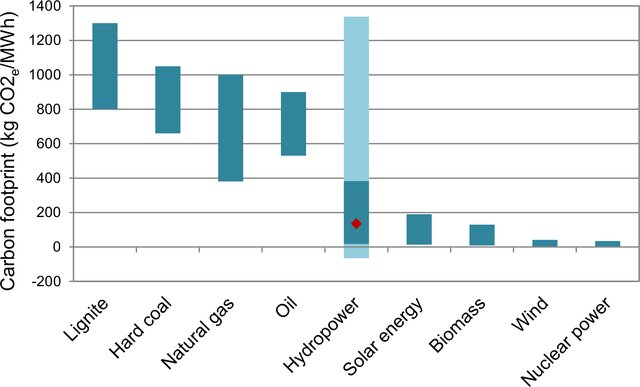

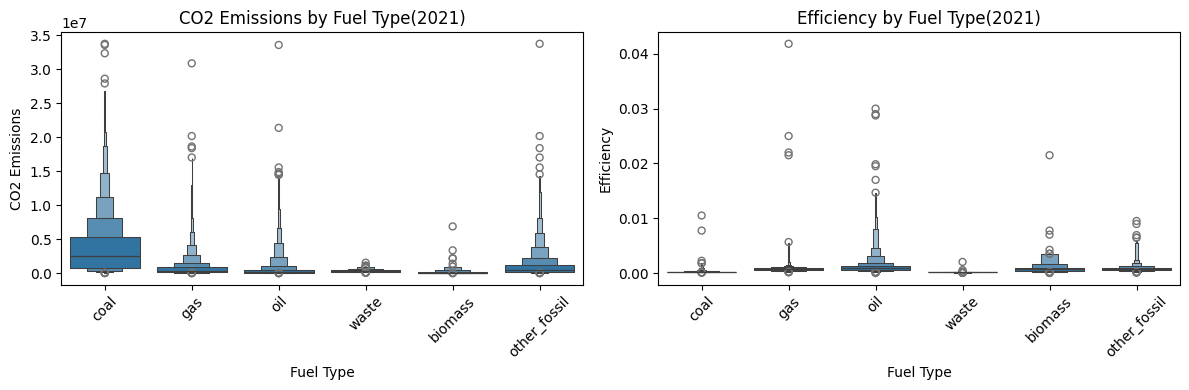

In [ ]:
types=['coal','gas','oil','waste','biomass','other_fossil']

for t in types:
  power_by_year_new[t]=power_by_year_new['AssetType'].apply(lambda x: 1 if t in x.lower() else 0)


power21 = pd.melt(power_by_year_new, id_vars=['co2_2021'], value_vars=types, var_name='FuelType', value_name='Present')
power21 = power21[power21['Present'] == 1]

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
sns.boxenplot(data=power21, x='FuelType', y='co2_2021')
plt.xlabel('Fuel Type')
plt.ylabel('CO2 Emissions')
plt.title('CO2 Emissions by Fuel Type(2021)')
plt.xticks(rotation=45)



power_by_new['efficiency']=power_by_year_new['Capacity']/power_by_year_new['co2_2021']

powereff = pd.melt(power_by_year_new, id_vars=['efficiency'], value_vars=types, var_name='FuelType', value_name='Present')
powereff = powereff[powereff['Present'] == 1]

plt.subplot(1,2,2)
sns.boxenplot(data=powereff, x='FuelType', y='efficiency')
plt.xlabel('Fuel Type')
plt.ylabel('Efficiency')
plt.title('Efficiency by Fuel Type(2021)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()



---


- Below, we can see the worldwide decreasing trends of emissions of coal and gas fired powerplants from 2021 to 2022. (I limited the lower limit of decrease_rate of coal as -2 so that the color maps match each other.)
- For coal, there were some countries with having a slight decrease in their coal-generated emissions - Brazil, Ukraine and plants in some countries, while places such as Mid to East Europe and India have increasing trends.
- Meantime, countries that had an increase in their coal emissions had a decrease in gas emissions. Furthermore, it can be seen that outside of North America, emissions are generally getting lower (the decrease rate is higher) than those of coal plants. With the exception of parts of Western Europe, emissions tend to remain the same or decrease.

- This trend is mainly due to the das-to-coal switching in many countries with the spiking natural gas prices(caused by Russian invasion). Even there was a decreasing trend in gas emissions, the increase of coal emissions led to an overall emission increase.

Text(0.5, 1.0, 'Emission Decrease Rate of Gas powerplants')

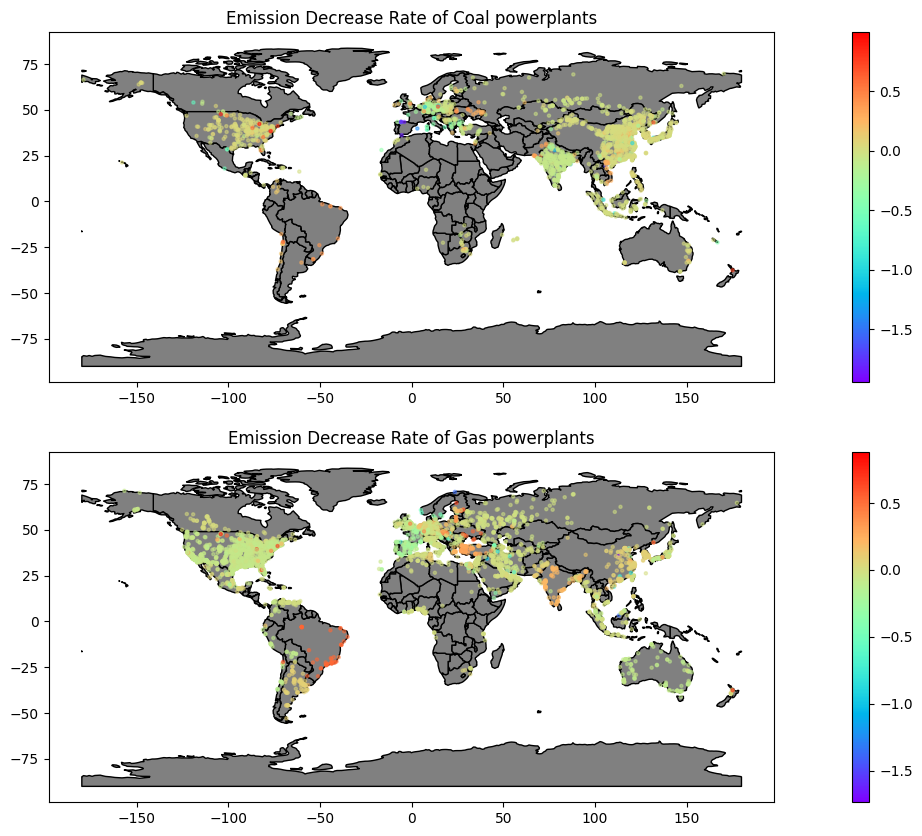

In [ ]:
fig,axes=plt.subplots(figsize=(20, 10),ncols=1,nrows=2)

coal=power_by_year_new[power_by_year_new['coal']==1]
coal=coal[coal['decrease_rate']>-2]
coal_gdf=geopandas.GeoDataFrame(coal,geometry=geopandas.points_from_xy(coal.lon,coal.lat))
world.plot(ax=axes[0],color='grey',edgecolor='black')
coal_gdf.plot(
    ax=axes[0],column='decrease_rate',cmap='rainbow',legend=True,markersize=5,alpha=0.5
)
axes[0].set_title('Emission Decrease Rate of Coal powerplants')


gas=power_by_year_new[power_by_year_new['gas']==1]
gas_gdf=geopandas.GeoDataFrame(gas,geometry=geopandas.points_from_xy(gas.lon,gas.lat))
world.plot(ax=axes[1],color='grey',edgecolor='black')
gas_gdf.plot(
    ax=axes[1],column='decrease_rate',cmap='rainbow',legend=True,markersize=5,alpha=0.5
)
axes[1].set_title('Emission Decrease Rate of Gas powerplants')



---


##### Specific trends of emissions depending on energy sources

- By identifying countries of Moldova, New Zealand, and Brazil with high decrease rate of emissions (as we discovered by plotting a choropleth map on emission decrease rate by countries, I plotted it again), we can gain insights into the importance of decreasing emissions, impact of energy sources on emissions, futhermore their trigger to environmental inequalities.
- I first asked gemini to give information of the relevant situations of these countries at 2021 and 2022 related to energy sources or electricity generation, so that I can narrow my web-searching direction.

Text(0.5, 1.0, 'Decrease rate of co2 emissions by countries')

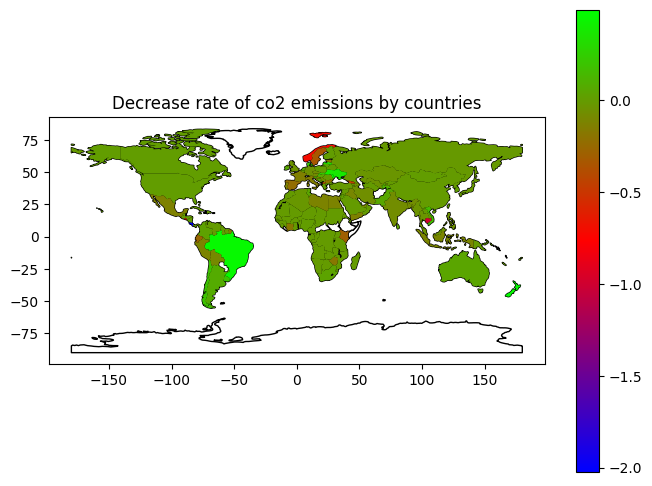

In [ ]:
fig,ax=plt.subplots(figsize=(8,6))

world.plot(
    ax=ax,color='white',edgecolor='black'
)
world_emissions.plot(
    ax=ax,column='decrease_rate',cmap='brg',legend=True
)
plt.title('Decrease rate of co2 emissions by countries')

In [ ]:
model=genai.GenerativeModel('gemini-pro')
response1=model.generate_content([f'''
{world_emissions} contain the sum co2 emissions by each country, due to the electricity generation sector of years 2021 and 2022.
The {['Country']} column of {world_emissions} is the name of the country.
The {['decrease_rate']} column of {world_emissions} is the co2 emission decreasion rate of that country from 2021 to 2022.
For example, the observation that has the {world_emissions['Country']=='BRA'} is the information of Brazil's electricity generation sector co2 emissions.

We can see that Brazil, Moldova, New Zealand has a large decrease rate in emissions from 2021 to 2022.
Are there any reasons that these countries have a large decrease rate in emissions?
Consider their energy generation sources, situations of the sources such as the energy crisis, weather conditions at that time series, and all possible informations.
'''])
response1.resolve()

In [ ]:
to_markdown(response1.text)

> **Brazil**
> 
> * **Increased use of renewable energy sources:** Brazil has been investing heavily in renewable energy sources, such as solar and wind power, in recent years. This has helped to reduce the country's reliance on fossil fuels, which are a major source of greenhouse gas emissions.
> * **Drought conditions:** Brazil experienced a severe drought in 2021, which led to a decrease in hydroelectric power generation. This forced the country to rely more on thermal power plants, which are more carbon-intensive than hydroelectric plants. However, the drought conditions eased in 2022, which allowed Brazil to increase its use of hydroelectric power and reduce its overall emissions.
> * **Energy conservation measures:** The Brazilian government has implemented a number of energy conservation measures in recent years, such as promoting the use of energy-efficient appliances and encouraging businesses to adopt more efficient production processes. These measures have helped to reduce the country's overall energy consumption, which has also contributed to a decrease in emissions.
> 
> **Moldova**
> 
> * **Reduced natural gas imports:** Moldova is heavily dependent on natural gas imports from Russia. However, in 2022, Russia reduced its gas exports to Moldova due to political tensions. This forced Moldova to find alternative sources of energy, such as coal and biomass. While these sources are more carbon-intensive than natural gas, they still resulted in a decrease in emissions compared to 2021, when Moldova was relying heavily on Russian gas.
> * **Energy efficiency measures:** The Moldovan government has also implemented a number of energy efficiency measures in recent years, such as promoting the use of energy-efficient appliances and encouraging businesses to adopt more efficient production processes. These measures have helped to reduce the country's overall energy consumption, which has also contributed to a decrease in emissions.
> 
> **New Zealand**
> 
> * **Increased use of renewable energy sources:** New Zealand has been investing heavily in renewable energy sources, such as solar and wind power, in recent years. This has helped to reduce the country's reliance on fossil fuels, which are a major source of greenhouse gas emissions.
> * **Favorable weather conditions:** New Zealand experienced favorable weather conditions in 2022, which led to an increase in hydroelectric power generation. This helped to reduce the country's reliance on thermal power plants, which are more carbon-intensive than hydroelectric plants.
> * **Energy conservation measures:** The New Zealand government has implemented a number of energy conservation measures in recent years, such as promoting the use of energy-efficient appliances and encouraging businesses to adopt more efficient production processes. These measures have helped to reduce the country's overall energy consumption, which has also contributed to a decrease in emissions.

 Based on the information gemini gave, I identified the trends of these countries, and we can earn some insigts - introduced below.

 - First, we should consider that with the economic rebound after the COVID-19 pandemic, during 2021 and 2022, there was a rising energy demand beyond the supply. (The rebound of 2021 was much higher than 2022)

##### Brazil

- At https://ember-climate.org/countries-and-regions/countries/brazil/ we can get information of Brazil's electricity generation by source.
- From 2021 to 2022, there was an increase in the absolute electricity generation amount(approximately 650 TW/h -> 680 TW/h), but simultaneously a significant decrease on emissions. The reasons for this was the shift of energy sources from 2021 to 2022, due to weather conditions. Brazil's emission decrease was not precisely due to the rapid development of renewable energy, but due to the high levels of emissions in 2021, with extreme weather conditions. The detailed figures are as follows:
- **Figure 1** shows the emissions generated by electricity generation in Brazil. There is a peak in 2021's emission quantities, but it is also noticeable that emissions in 2022 are also quite low compared to 2020. Especially, the emissions by gas highly increased in 2021.
- **Figure 2** shows the percentage share of electricity generation by sources. The sources that are the main emissions factors, are at the bottom of the chart, and their stake reduced by more than half. Meanwhile, the proportion of hydro increased from 2021 55.30% to 2022 63.70%

---



[Figure 1]
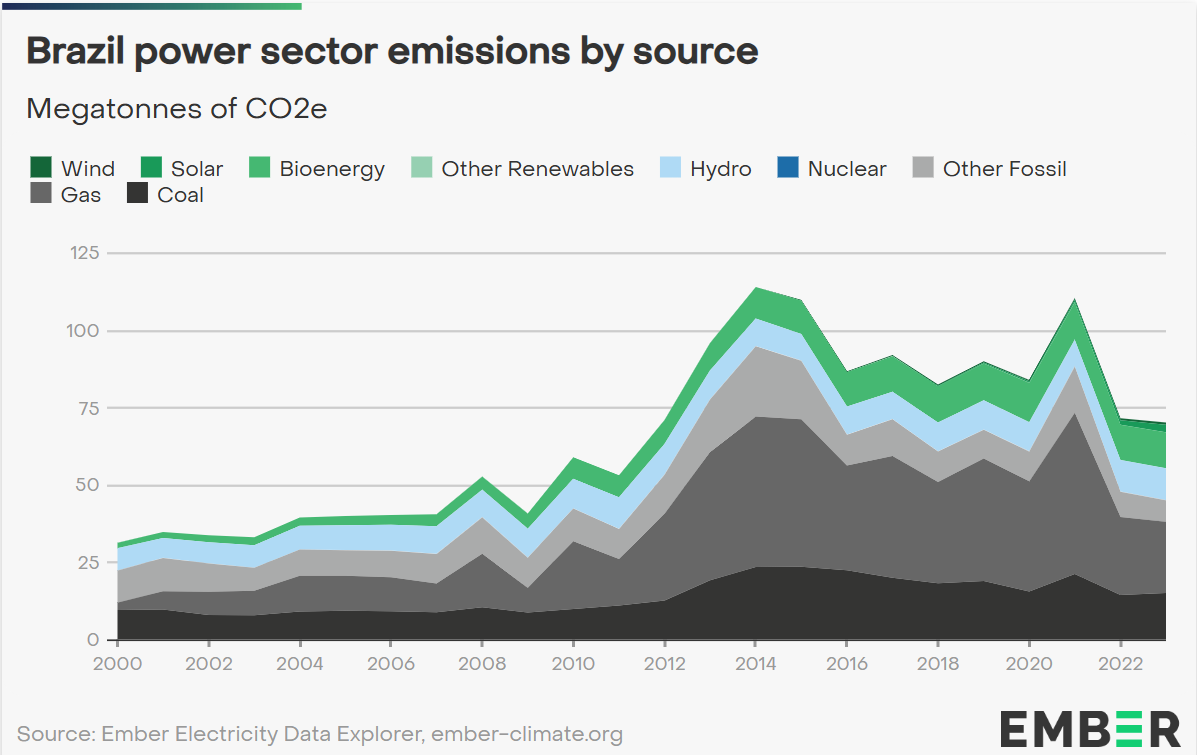

[Figure 2]
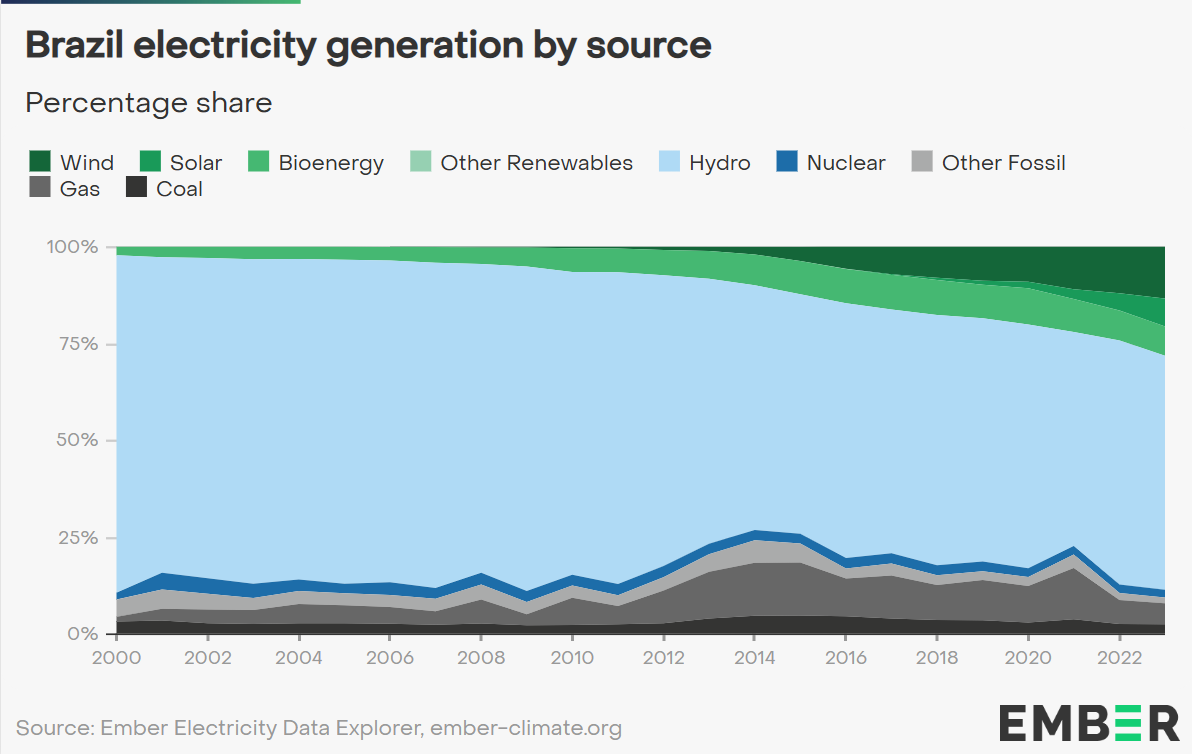

- We can also see the change of emissions by sources in Brazil through the climatetrace data.
- By grouping the data of Brazil on 'AssetType' and summing the emissions, and creating a dataframe to plot a bar chart, we can plot a stacked bar chart that shows the composition of energy sources on emissions.
- In the climatetrace dataset, the emission quantity generated by coal is a little bigger, but aside of that, we can derive same conclusions that Brazil has a significant decrease on their emissions from mainly coal and gas.

In [ ]:
brazil=power[power['Country']=='BRA']

brazil_2021=brazil[brazil['year']==2021]
brazil_2022=brazil[brazil['year']==2022]

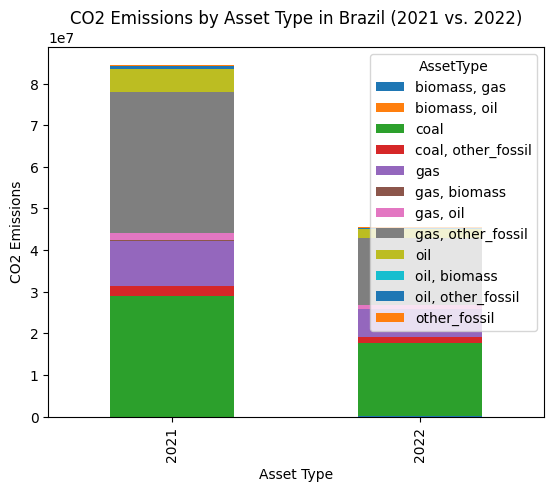

In [ ]:
brazil=power[power['Country']=='BRA']

brazil_2021=brazil[brazil['year']==2021]
brazil_2022=brazil[brazil['year']==2022]

brazil_2021_grouped = brazil_2021.groupby('AssetType')['co2'].sum()
brazil_2022_grouped = brazil_2022.groupby('AssetType')['co2'].sum()

df_plot = pd.DataFrame({'2021': brazil_2021_grouped, '2022': brazil_2022_grouped})

df_plot.T.plot(kind='bar', stacked=True)
plt.xlabel('Asset Type')
plt.ylabel('CO2 Emissions')
plt.title('CO2 Emissions by Asset Type in Brazil (2021 vs. 2022)')
plt.show()


- The reason Brazil had a reduction in their hydropower electricity generation was the severe drought they faced in 2021. [https://energy-analytics-institute.org/2021/12/08/brazil-is-in-water-crisis/] According to the 2021 Intergovernmental Panel on Climate Change(IPCC) report, regional land-cover change and global warming are causing these continuing dry conditions.
- Due to these droughts, to recover the energy drop in hydropower, Brazil had to activate thermoelectric plants, mainly using natural gas as power sources, which drive up greenhouse gas emissions.


---

- The example of Brazil provides these insights:
  - 1) Increasing climate change due to continuous carbon emissions can prevent the increase in the production of renewable energy, which is an efficient way to reduce carbon emissions. In particular, methods that are highly affected by weather, such as hydro power, are even more vulnerable to climate change. The depletion of these energy sources will be a major obstacle to our steps towards climate change prevention. It shows that the reduction of carbon emissions and the transition to other renewable energy sources are more urgent before climate change intensifies.
  - 2) Furthermore, it shows that even a small increase (or recovery) in renewable energy production can significantly reduce carbon emissions. In particular, it shows the enormous emissions of electricity generation from natural gas or oil. Also, in preparation for the decline in hydro power generation due to climate change, it is necessary to expand other energy sources as well, such as solar power.

---


##### New Zealand

- The electricity generation sources of New Zealand have somewhat a similar pattern with those of Brazil - https://ember-climate.org/countries-and-regions/regions/world/ (at New Zealand section)
- According to the 'Energy in New Zealand 22' provided by Ministry of Business, Innovation & Employment of New Zealand Government(https://www.mbie.govt.nz/dmsdocument/23550-energy-in-new-zealand-2022-pdf), there was an increase in coal use for electricity generation, due to lower hydro and natural gas production(p47), with higher demand of energy due to recovery after COVID. As analyzed in the data from climate trace, Huntly power plant had an increase in its activity, and this leaded to a high emission level of New Zealand in 2021(as seen in **Figure 1**, the peak of coal sources).
- Huntly power plant was the only plant in New Zealand with high decrease rates, according to the individual plants map we plotted. Our data analysis connects to the context.
- cf) The fall of hydro generation was caused by La Niña conditions.
- Still, as seen in **Figure 2**, New Zealand is making an increase in renewable shares of energy consistently. Wind generation is steadily increasing, and other renewable sources such as geothermal has a steady proportion of New Zealand's electricity generation.

[Figure 1]
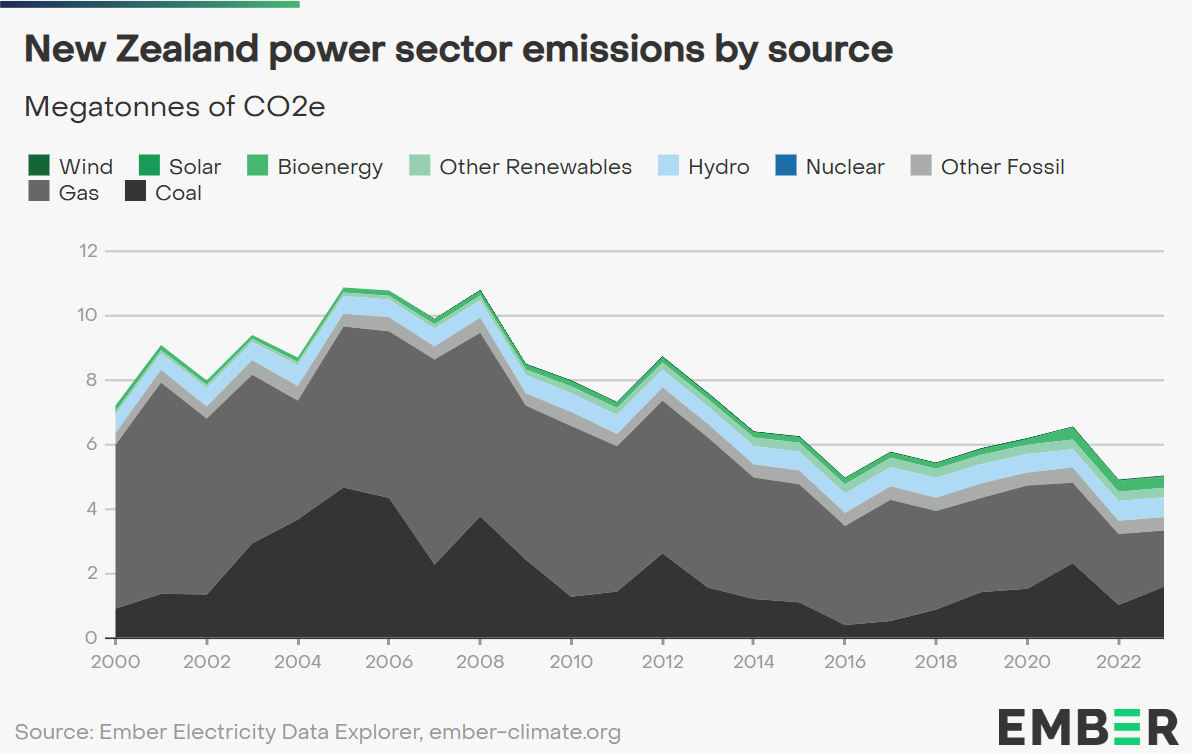
[Figure 2]
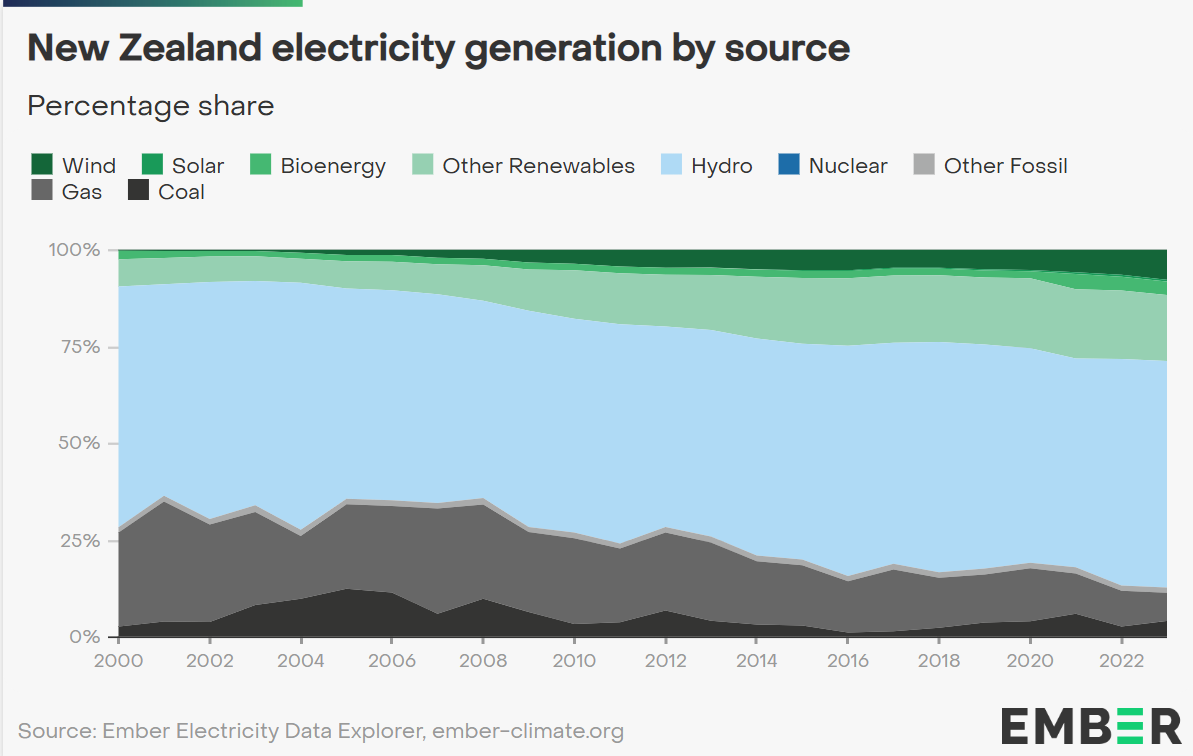



---


- Insights from New Zealand
  - New Zealand's energy sources for 2021 and 2022 provide a glimpse into the positive effects of reducing emissions through the expansion of renewable energy sources. Although there was a jump in emissions in 2021, this was to cover up the increase in energy demand after the COVID pandemic. There has also been an increase in renewable energy sources during this period, with the expansion of renewable energy sources in 2022. At the same time, it shows that electricity generation from coal has a significant impact on emissions and is devastating to the environment.
  - Moreover, New Zealand's situation shows that it is likely that fossil fuel electricity generation will have to remain somehow. While renewable generation is intermittent, before energy storage in a large-scale is possible, fossil-fuelled generation will have its portion in the market. We will have to find ways to solve these problems.


---



##### Moldova
- The reasons for Moldova's emissions reductions are quite different from those of the other two cities. Natural gas accounts for the majority of Moldova's electricity production, and Moldova's electricity production has declined compared to two countries that have seen an increase in demand and production due to the recovery from the pandemic.
- As shown in **Figure 1** below,gas occupies approximately 90% of Moldova's electricity generation, and the quantities of electricity generation fell from 7TW/h to 5TW/h.

[Figure 1]
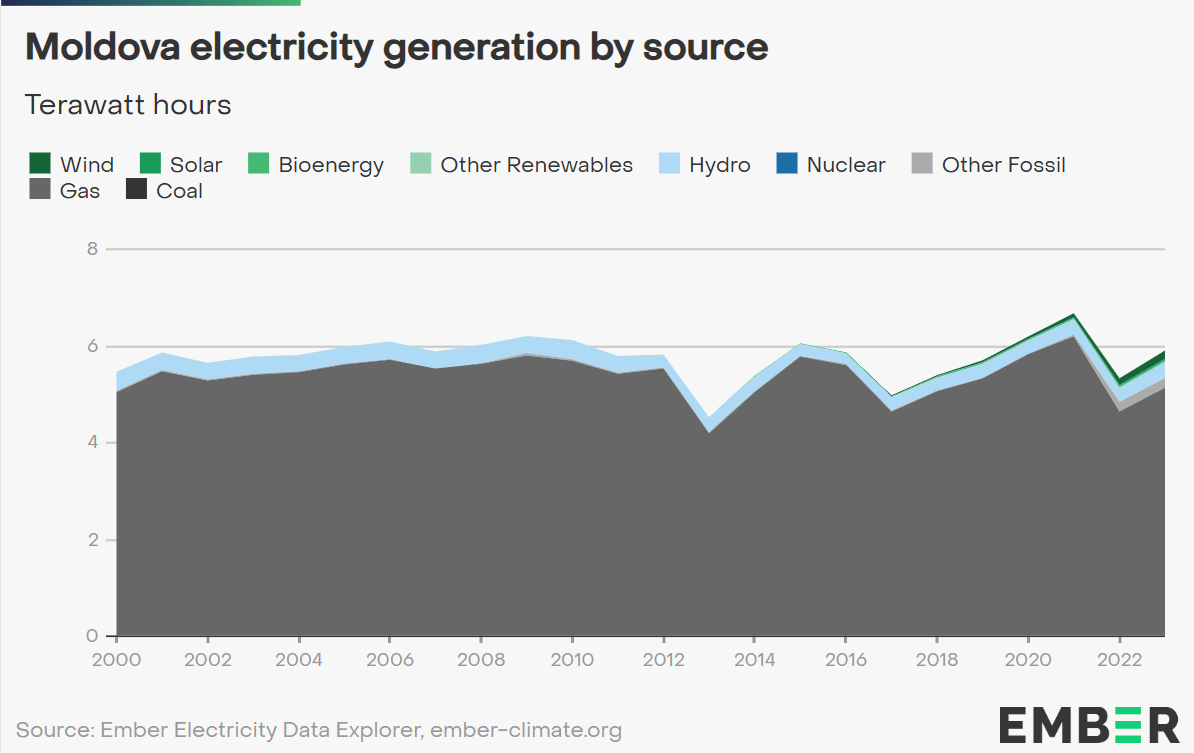

- The decrease of electricity generation from gas was due to Moldova's dependent energy supplies on Russia. Starting late 2021, right before the Russian invasion of Ukraine, Moldova's energy crisis started.
- According to https://www.german-economic-team.com/en/newsletter/moldova-is-making-some-progress-on-energy-security/.
- The import price of gas significantly increased after the last contract between Gazprom and Moldovagax ended. Moldova was able to overcome this by the financial support from the EU, however, international gas prices remained high, with Moldova facing an energy crisis that goes beyond the gas crisis. As source of electricity from Ukraine also stopped due to the destruction of Ukraine's energy infrastructure, Moldova had to struggle to import natural gas at a high price, from Romania. Due to this, electricity generation decreased in Moldova, also causing a few times of blackout of Moldova.
- While other countries in Europe facing the high natural gas had an alternative of coal plants, Moldova was highly dependent on gas as an energy source. This led to a decrease in Moldova's electricity generation, connected to reduced emissions.

---

- The case of Moldova illustrates the problems of power supply that arise when we become dependent on certain energy sources, especially limited resources such as natural gas, and the resulting environmental inequality. Lack of access to electricity is ultimately fatal for the poor within countries, or for developing countries.
- It also highlights the need for sustainable energy sources. It is not just about reducing emissions to prevent climate change, but also about reducing energy sources such as coal and gas, which are limited and may run out some time.

---






##### Energy Sources and Emissions

- Following the emissions rebound in 2021, the increase in energy demand due to the economic recovery after the pandemic continued in 2022 (albeit to a small extent).
  - Coal-fired plants tend to have higher amounts of co2 emission compared to other fossil fuels (due to its high carbon content and the inefficient combustion techniqurs)
  - The main source of the emissions increase was the gas-to-coal switch in some countries, due to the rising prices of natural gas (with the Russian invasion on Ukraine).
- By analyzing the energy sources and the relevant situations of the three countries with significant emission reduction, we can derive conclusions of the importance of energy sources in electricity generation.
  - New Zealand represents a good example of expanding its energy sources of renewable sources, also highlighting the large impact of coal power plants on emissions.
  - The severe drought of Brazil in 2021 and its effects show our desperate needs to deal with climate change, related to its impact on renewable energy sources.
  - Finally, Moldova indicates the need of sustainable energy sources, other than gas or coal, also showing possible threats of environmental inequalities that may happen in the distant future.


---


### Conclusion

We took a closer look at the trends in overall and energy source emissions from electricity generation between 2021 and 2022, as well as the situation in specific countries. This gave us insight into the impact of the state of energy sources on emissions, the importance of tackling the climate crisis, and the direction we need to take in the future. If the shift to coal continues, it will be difficult to reduce emissions, even as the share of renewables increases (due to the offset that the coal-fired plants make).

With the continuing rise of energy demand as recovery of the pandemic and the instability of the supply of certain energy sources, the world's co2 emissions from electricity generation has climbed during 2021 and 2022. Moreover, some cases of emission rise due to extreme weather stories give us an alert of facing climate change. As fossil fuels are limited resources, price increases can happen at any time, which can lead to a widening disparity in environmental inequality due to higher electricity costs. The lesson is that if we don't prepare quickly for renewables, climate change and resource scarcity due to the cumulative impact of emissions will become even more of a threat in the future. As such, monitoring(predicting), regulating, and reducing greenhouse gas emissions to prevent climate change is important, and the analysis of relevant data is also crucial, so that we can see more sustainable trends in the sector of electricity generation.